## All imports

In [1]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
from collections import Counter
import torch.utils.data as data
import torch.optim as optim
from pprint import pprint
import matplotlib as mp
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import random
import torch
import json
import os

import random
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import os
import json
from pprint import pprint
import torch.optim as optim
import sklearn
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd

import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()
# Global variables
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # cuda:0 means we are using the GPU with id 0, if you have multiple GPU
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # Used to report errors on CUDA side
PAD_TOKEN = 0

## Importing DATABASE

In [2]:
!git clone https://github.com/BrownFortress/IntentSlotDatasets

Cloning into 'IntentSlotDatasets'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 40 (delta 9), reused 25 (delta 6), pack-reused 0
Unpacking objects: 100% (40/40), 1.05 MiB | 4.97 MiB/s, done.


## Functions in cnll.py file

In [4]:
import re

"""
Modified version of https://pypi.org/project/conlleval/
"""


def stats():
    return {'cor': 0, 'hyp': 0, 'ref': 0}


def evaluate(ref, hyp, otag='O'):
    # evaluation for NLTK
    aligned = align_hyp(ref, hyp)
    return conlleval(aligned, otag=otag)


def align_hyp(ref, hyp):
    # align references and hypotheses for evaluation
    # add last element of token tuple in hyp to ref
    if len(ref) != len(hyp):
        raise ValueError("Size Mismatch: ref: {} & hyp: {}".format(len(ref), len(hyp)))

    out = []
    for i in range(len(ref)):
        if len(ref[i]) != len(hyp[i]):
            raise ValueError("Size Mismatch: ref: {} & hyp: {}".format(len(ref), len(hyp)))
        out.append([(*ref[i][j], hyp[i][j][-1]) for j in range(len(ref[i]))])
    return out


def conlleval(data, otag='O'):
    # token, segment & class level counts for TP, TP+FP, TP+FN
    tok = stats()
    seg = stats()
    cls = {}

    for sent in data:

        prev_ref = otag      # previous reference label
        prev_hyp = otag      # previous hypothesis label
        prev_ref_iob = None  # previous reference label IOB
        prev_hyp_iob = None  # previous hypothesis label IOB

        in_correct = False  # currently processed chunks is correct until now

        for token in sent:

            hyp_iob, hyp = parse_iob(token[-1])
            ref_iob, ref = parse_iob(token[-2])

            ref_e = is_eoc(ref, ref_iob, prev_ref, prev_ref_iob, otag)
            hyp_e = is_eoc(hyp, hyp_iob, prev_hyp, prev_hyp_iob, otag)

            ref_b = is_boc(ref, ref_iob, prev_ref, prev_ref_iob, otag)
            hyp_b = is_boc(hyp, hyp_iob, prev_hyp, prev_hyp_iob, otag)

            if not cls.get(ref) and ref:
                cls[ref] = stats()

            if not cls.get(hyp) and hyp:
                cls[hyp] = stats()

            # segment-level counts
            if in_correct:
                if ref_e and hyp_e and prev_hyp == prev_ref:
                    in_correct = False
                    seg['cor'] += 1
                    cls[prev_ref]['cor'] += 1

                elif ref_e != hyp_e or hyp != ref:
                    in_correct = False

            if ref_b and hyp_b and hyp == ref:
                in_correct = True

            if ref_b:
                seg['ref'] += 1
                cls[ref]['ref'] += 1

            if hyp_b:
                seg['hyp'] += 1
                cls[hyp]['hyp'] += 1

            # token-level counts
            if ref == hyp and ref_iob == hyp_iob:
                tok['cor'] += 1

            tok['ref'] += 1

            prev_ref = ref
            prev_hyp = hyp
            prev_ref_iob = ref_iob
            prev_hyp_iob = hyp_iob

        if in_correct:
            seg['cor'] += 1
            cls[prev_ref]['cor'] += 1

    return summarize(seg, cls)


def parse_iob(t):
    m = re.match(r'^([^-]*)-(.*)$', t)
    return m.groups() if m else (t, None)


def is_boc(lbl, iob, prev_lbl, prev_iob, otag='O'):
    """
    is beginning of a chunk

    supports: IOB, IOBE, BILOU schemes
        - {E,L} --> last
        - {S,U} --> unit

    :param lbl: current label
    :param iob: current iob
    :param prev_lbl: previous label
    :param prev_iob: previous iob
    :param otag: out-of-chunk label
    :return:
    """
    boc = False

    boc = True if iob in ['B', 'S', 'U'] else boc
    boc = True if iob in ['E', 'L'] and prev_iob in ['E', 'L', 'S', otag] else boc
    boc = True if iob == 'I' and prev_iob in ['S', 'L', 'E', otag] else boc

    boc = True if lbl != prev_lbl and iob != otag and iob != '.' else boc

    # these chunks are assumed to have length 1
    boc = True if iob in ['[', ']'] else boc

    return boc


def is_eoc(lbl, iob, prev_lbl, prev_iob, otag='O'):
    """
    is end of a chunk

    supports: IOB, IOBE, BILOU schemes
        - {E,L} --> last
        - {S,U} --> unit

    :param lbl: current label
    :param iob: current iob
    :param prev_lbl: previous label
    :param prev_iob: previous iob
    :param otag: out-of-chunk label
    :return:
    """
    eoc = False

    eoc = True if iob in ['E', 'L', 'S', 'U'] else eoc
    eoc = True if iob == 'B' and prev_iob in ['B', 'I'] else eoc
    eoc = True if iob in ['S', 'U'] and prev_iob in ['B', 'I'] else eoc

    eoc = True if iob == otag and prev_iob in ['B', 'I'] else eoc

    eoc = True if lbl != prev_lbl and iob != otag and prev_iob != '.' else eoc

    # these chunks are assumed to have length 1
    eoc = True if iob in ['[', ']'] else eoc

    return eoc


def score(cor_cnt, hyp_cnt, ref_cnt):
    # precision
    p = 1 if hyp_cnt == 0 else cor_cnt / hyp_cnt
    # recall
    r = 0 if ref_cnt == 0 else cor_cnt / ref_cnt
    # f-measure (f1)
    f = 0 if p+r == 0 else (2*p*r)/(p+r)
    return {"precision": p, "recall": r, "f-measure": f, "support": ref_cnt}


def summarize(seg, cls):
    # class-level
    res = {lbl: score(cls[lbl]['cor'], cls[lbl]['hyp'], cls[lbl]['ref']) for lbl in set(cls.keys())}
    # micro
    res.update({"total": score(seg.get('cor', 0), seg.get('hyp', 0), seg.get('ref', 0))})
    return res


def read_corpus_conll(corpus_file, fs="\t"):
    """
    read corpus in CoNLL format
    :param corpus_file: corpus in conll format
    :param fs: field separator
    :return: corpus
    """
    featn = None  # number of features for consistency check
    sents = []  # list to hold words list sequences
    words = []  # list to hold feature tuples

    for line in open(corpus_file):
        line = line.strip()
        if len(line.strip()) > 0:
            feats = tuple(line.strip().split(fs))
            if not featn:
                featn = len(feats)
            elif featn != len(feats) and len(feats) != 0:
                raise ValueError("Unexpected number of columns {} ({})".format(len(feats), featn))

            words.append(feats)
        else:
            if len(words) > 0:
                sents.append(words)
                words = []
    return sents


def get_chunks(corpus_file, fs="\t", otag="O"):
    sents = read_corpus_conll(corpus_file, fs=fs)
    return set([parse_iob(token[-1])[1] for sent in sents for token in sent if token[-1] != otag])

# Data Utils

The function then loads the train and test datasets for two different datasets, 'ATIS' and 'SNIPS', and prints the number of samples in each dataset. 
It also prints a random sample of 5 items from each dataset by using random.sample function.

In [5]:
def load_data(path):
    '''
        input: path/to/data
        output: json 
    '''
    dataset = []
    with open(path) as f:
        dataset = json.loads(f.read())
    return dataset

ATIS_tmp_train_raw = load_data(os.path.join('/content/IntentSlotDatasets','ATIS','train.json'))
ATIS_test_raw = load_data(os.path.join('/content/IntentSlotDatasets','ATIS','test.json'))
print('='*89)
print('Train samples:', len(ATIS_tmp_train_raw))
print('Test samples:', len(ATIS_test_raw))
print('='*89)

SNIPS_train_raw = load_data(os.path.join('/content/IntentSlotDatasets','SNIPS','train.json'))
SNIPS_test_raw = load_data(os.path.join('/content/IntentSlotDatasets','SNIPS','test.json'))
SNIPS_dev_raw = load_data(os.path.join('/content/IntentSlotDatasets','SNIPS','valid.json'))
print('Train samples:', len(SNIPS_train_raw))
print('Test samples:', len(SNIPS_test_raw))
print('Dev samples:', len(SNIPS_dev_raw))
print('='*89)

ATIS_indices = random.sample(range(len(ATIS_tmp_train_raw)), 5)
SNIPS_indices = random.sample(range(len(SNIPS_train_raw)), 5)

for index in ATIS_indices:
  pprint(ATIS_tmp_train_raw[index])
print('='*89)
for index in SNIPS_indices:
  pprint(SNIPS_train_raw[index])
print('='*89)

Train samples: 4978
Test samples: 893
Train samples: 13084
Test samples: 700
Dev samples: 700
{'intent': 'flight',
 'slots': 'O O O O O O O B-fromloc.city_name I-fromloc.city_name '
          'I-fromloc.city_name O B-toloc.city_name B-toloc.country_name O '
          'B-depart_date.day_name O O B-depart_time.period_of_day',
 'utterance': 'i need a listing of flights from new york city to montreal '
              'canada departing thursday in the morning'}
{'intent': 'airline',
 'slots': 'O O O B-airline_code',
 'utterance': 'what is airline dl'}
{'intent': 'flight',
 'slots': 'O O O O B-fromloc.city_name I-fromloc.city_name O '
          'B-depart_date.day_name O O O B-toloc.city_name',
 'utterance': 'show any flights leaving san francisco on sunday and arriving '
              'in pittsburgh'}
{'intent': 'flight',
 'slots': 'O B-airline_name O O B-depart_time.period_of_day '
          'B-depart_time.period_of_day O O B-fromloc.city_name O '
          'B-toloc.city_name I-toloc.city_na

We take a portion of the ATIS training and test data and splits it into three sets: train, dev, and test. The portion of the data that will be used for dev set is calculated by taking 10% of the total number of samples in both the train and test datasets, and then stratifying the data based on the 'intent' attribute of each sample. 
Then we remove any intents that only appear once in the dataset, as it makes no sense to put those in the dev set. 
Finally, we use the train_test_split function to split the data into train and dev sets, and then extends the train set with the intents that were removed earlier.And then we print the size of each dataset (train, dev, and test).

In [6]:
portion = round(((len(ATIS_tmp_train_raw) + len(ATIS_test_raw)) * 0.10)/(len(ATIS_tmp_train_raw)),2)

ATIS_intents = [x['intent'] for x in ATIS_tmp_train_raw] # We stratify on intents
ATIS_count_y = Counter(ATIS_intents)

ATIS_X = []
ATIS_Y = []
ATIS_mini_Train = []

for id_y, y in enumerate(ATIS_intents):
    if ATIS_count_y[y] > 1: # Some intents have only one instance, we put them in training
        ATIS_X.append(ATIS_tmp_train_raw[id_y])
        ATIS_Y.append(y)
    else:
        ATIS_mini_Train.append(ATIS_tmp_train_raw[id_y])
# Random Stratify
ATIS_X_train, ATIS_X_dev, ATIS_y_train, ATIS_y_dev = train_test_split(ATIS_X, ATIS_Y, test_size=portion, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                    stratify=ATIS_Y)
ATIS_X_train.extend(ATIS_mini_Train)
ATIS_train_raw = ATIS_X_train
ATIS_dev_raw = ATIS_X_dev

y_test_ATIS = [x['intent'] for x in ATIS_test_raw]

# Dataset size
print('='*89)
print('TRAIN size:', len(ATIS_train_raw))
print('='*89)
print('DEV size:', len(ATIS_dev_raw))
print('='*89)
print('TEST size:', len(ATIS_test_raw))
print('='*89)

TRAIN size: 4381
DEV size: 597
TEST size: 893


Lang function to map words, slots, intents to unique id's.

In [7]:
class Lang():
    def __init__(self, words, intents, slots, cutoff=0):
        self.word2id = self.w2id(words, cutoff=cutoff, unk=True)
        self.slot2id = self.lab2id(slots)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v:k for k, v in self.word2id.items()}
        self.id2slot = {v:k for k, v in self.slot2id.items()}
        self.id2intent = {v:k for k, v in self.intent2id.items()}
        
    def w2id(self, elements, cutoff=None, unk=True):
        vocab = {'pad': PAD_TOKEN}
        if unk:
            vocab['unk'] = len(vocab)
        count = Counter(elements)
        for k, v in count.items():
            if v > cutoff:
                vocab[k] = len(vocab)
        return vocab
    
    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in elements:
                vocab[elem] = len(vocab)
        return vocab

ATIS_words: iterating through each sample in 'ATIS_train_raw' and getting the 'utterance' field, then splitting it into words.

ATIS_corpus: concatenating the lists 'ATIS_train_raw', 'ATIS_dev_raw', and 'ATIS_test_raw'.

ATIS_slots: iterating through each sample in 'ATIS_corpus' and getting the 'slots' field, then splitting it into slots and adding it to the set.

ATIS_intents: iterating through each sample in 'ATIS_corpus' and getting the 'intent' field, then adding it to the set.

ATIS_lang: instance of the Lang class by passing in the three sets created earlier and an optional 'cutoff' parameter. This will initialize the class and create the three dictionaries word2id, slot2id, and intent2id.

In [8]:
# Create a list of all the words in the 'utterance' field of each sample in ATIS_train_raw
ATIS_words = [word for line in ATIS_train_raw for word in line['utterance'].split()]

# Concatenate the lists ATIS_train_raw, ATIS_dev_raw, and ATIS_test_raw
ATIS_corpus = ATIS_train_raw + ATIS_dev_raw + ATIS_test_raw

# Create a set of all the slot names in ATIS_corpus
ATIS_slots = set(slot for line in ATIS_corpus for slot in line['slots'].split())

# Create a set of all the intent names in ATIS_corpus
ATIS_intents = set(line['intent'] for line in ATIS_corpus)

# Instantiate the Lang class
ATIS_lang = Lang(ATIS_words, ATIS_intents, ATIS_slots, cutoff=0)


SNIPS_words: iterating through each sample in 'SNIPS_train_raw' and getting the 'utterance' field, then splitting it into words.

SNIPS_corpus: concatenating the lists 'SNIPS_train_raw', 'SNIPS_dev_raw', and 'SNIPS_test_raw'.

SNIPS_slots: iterating through each sample in 'SNIPS_corpus' and getting the 'slots' field, then splitting it into slots and adding it to the set.

SNIPS_intents: iterating through each sample in 'SNIPS_corpus' and getting the 'intent' field, then adding it to the set.

SNIPS_lang: instance of the Lang class by passing in the three sets created earlier and an optional 'cutoff' parameter. This will initialize the class and create the three dictionaries word2id, slot2id, and intent2id.

In [9]:
# Create a list of all the words in the 'utterance' field of each sample in SNIPS_train_raw
SNIPS_words = [word for line in SNIPS_train_raw for word in line['utterance'].split()]

# Concatenate the lists SNIPS_train_raw, SNIPS_dev_raw, and SNIPS_test_raw
SNIPS_corpus = SNIPS_train_raw + SNIPS_dev_raw + SNIPS_test_raw

# Create a set of all the slot names in SNIPS_corpus
SNIPS_slots = set(slot for line in SNIPS_corpus for slot in line['slots'].split())

# Create a set of all the intent names in SNIPS_corpus
SNIPS_intents = set(line['intent'] for line in SNIPS_corpus)

# Instantiate the Lang class
SNIPS_lang = Lang(SNIPS_words, SNIPS_intents, SNIPS_slots, cutoff=0)


A print of the first 5 items of each of the three dictionaries, word2id, intent2id, and slot2id, that were created when the Lang class was instantiated.  
The word2id dictionary maps words to unique integers, the intent2id dictionary maps intent names to unique integers, and the slot2id dictionary maps slot names to unique integers.

In [10]:
print('='*89)
print(list(ATIS_lang.word2id.items())[:5])
print('='*89)
print(list(ATIS_lang.intent2id.items())[:5])
print('='*89)
print(list(ATIS_lang.slot2id.items())[:5])
print('='*89)

[('pad', 0), ('unk', 1), ('what', 2), ('type', 3), ('of', 4)]
[('airline+flight_no', 0), ('flight_time', 1), ('cheapest', 2), ('aircraft', 3), ('restriction', 4)]
[('pad', 0), ('I-city_name', 1), ('B-stoploc.airport_code', 2), ('B-toloc.airport_code', 3), ('I-depart_time.time_relative', 4)]


In [11]:
print('='*89)
print(list(SNIPS_lang.word2id.items())[:5])
print('='*89)
print(list(SNIPS_lang.intent2id.items())[:5])
print('='*89)
print(list(SNIPS_lang.slot2id.items())[:5])
print('='*89)

[('pad', 11250), ('unk', 1), ('listen', 2), ('to', 3), ('westbam', 4)]
[('SearchScreeningEvent', 0), ('RateBook', 1), ('SearchCreativeWork', 2), ('AddToPlaylist', 3), ('PlayMusic', 4)]
[('pad', 0), ('I-restaurant_name', 1), ('I-service', 2), ('B-restaurant_name', 3), ('I-playlist', 4)]


Class used to convert the data into numerical format.

In [12]:
import torch
import torch.utils.data as data

class IntentsAndSlots(data.Dataset):
    # Mandatory methods are __init__, __len__ and __getitem__
    def __init__(self, dataset, lang, unk='unk'):
        self.utterances = []
        self.intents = []
        self.slots = []
        self.unk = unk
        
        for x in dataset:
            self.utterances.append(x['utterance'])
            self.slots.append(x['slots'])
            self.intents.append(x['intent'])

    # Convert to numbers
        self.utt_ids = self.mapping_seq(self.utterances, lang.word2id)
        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        # Get the sequence of word ids for the given index
        utt = torch.Tensor(self.utt_ids[idx])
        # Get the sequence of slot ids for the given index
        slots = torch.Tensor(self.slot_ids[idx])
        # Get the intent id for the given index
        intent = self.intent_ids[idx]
        # Return a sample with the sequence of word ids, sequence of slot ids, and intent id
        sample = {'utterance': utt, 'slots': slots, 'intent': intent}
        return sample 
    
    # Auxiliary methods
    
    def mapping_lab(self, data, mapper):
        """
        Map a list of labels to a list of integers using the given mapping.
        If a label is not in the mapping, it is mapped to the integer corresponding to the "unk" key.
        """      
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]
    
    def mapping_seq(self, data, mapper): 
        """
        Map a list of sequences of tokens to a list of sequences of integers using the given mapping.
        If a token is not in the mapping, it is mapped to the integer corresponding to the "unk" key.
        """
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq.split():
                if x in mapper:
                    tmp_seq.append(mapper[x])
                else:
                    tmp_seq.append(mapper[self.unk])
            res.append(tmp_seq)
        return res


Creation of dataset objects for training, validation and test for both ATIS and SNIPS datasets.

In [13]:
# Create ATIS datasets

ATIS_train_dataset = IntentsAndSlots(ATIS_train_raw, ATIS_lang)
ATIS_dev_dataset = IntentsAndSlots(ATIS_dev_raw, ATIS_lang)
ATIS_test_dataset = IntentsAndSlots(ATIS_test_raw, ATIS_lang)

# Create SNIPS datasets

SNIPS_train_dataset = IntentsAndSlots(SNIPS_train_raw, SNIPS_lang)
SNIPS_dev_dataset = IntentsAndSlots(SNIPS_dev_raw, SNIPS_lang)
SNIPS_test_dataset = IntentsAndSlots(SNIPS_test_raw, SNIPS_lang)

In [14]:
print('='*89)
print(f'Size of ATIS train dataset: {len(ATIS_train_dataset)}')
print(f'Size of ATIS dev dataset: {len(ATIS_dev_dataset)}')
print(f'Size of ATIS test dataset: {len(ATIS_test_dataset)}')
print('='*89)
print(f'Size of SNIPS train dataset: {len(SNIPS_train_dataset)}')
print(f'Size of SNIPS dev dataset: {len(SNIPS_dev_dataset)}')
print(f'Size of SNIPS test dataset: {len(SNIPS_test_dataset)}')
print('='*89)

Size of ATIS train dataset: 4381
Size of ATIS dev dataset: 597
Size of ATIS test dataset: 893
Size of SNIPS train dataset: 13084
Size of SNIPS dev dataset: 700
Size of SNIPS test dataset: 700


A function that sorts and collates the input data into tensors ready for use in a PyTorch DataLoader. It sorts the data by the length of the 'utterance' field in descending order, creates tensors for the source utterance, intent and y_slots and the lengths of the slots and loads these tensors on the specified device.  
It returns a dictionary containing all the collated data.

In [15]:
from torch.utils.data import DataLoader

def collate_fn(data):
    def merge(sequences):
        '''
        merge from batch * sent_len to batch * max_len 
        '''
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        # Pad token is zero in our case
        # So we create a matrix full of PAD_TOKEN (i.e. 0) with the shape 
        # batch_size X maximum length of a sequence
        padded_seqs = torch.LongTensor(len(sequences), max_len).fill_(PAD_TOKEN)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq # We copy each sequence into the matrix
        # print(padded_seqs)
        padded_seqs = padded_seqs.detach()  # We remove these tensors from the computational graph
        return padded_seqs, lengths
        
    # Sort data by seq lengths
    data.sort(key=lambda x: len(x['utterance']), reverse=True) 
    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
    # We just need one length for packed pad seq, since len(utt) == len(slots)
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt.to(device) # We load the Tensor on our seleceted device
    y_slots = y_slots.to(device)
    intent = intent.to(device)
    y_lengths = torch.LongTensor(y_lengths).to(device)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths
    return new_item

In [16]:
# ATIS Dataloaders 

ATIS_train_loader = DataLoader(ATIS_train_dataset, batch_size=128, collate_fn=collate_fn,  shuffle=True)
ATIS_dev_loader = DataLoader(ATIS_dev_dataset, batch_size=64, collate_fn=collate_fn)
ATIS_test_loader = DataLoader(ATIS_test_dataset, batch_size=64, collate_fn=collate_fn)

In [17]:
# SNIPS Dataloaders

SNIPS_train_loader = DataLoader(SNIPS_train_dataset, batch_size=128, collate_fn=collate_fn,  shuffle=True)
SNIPS_dev_loader = DataLoader(SNIPS_dev_dataset, batch_size=64, collate_fn=collate_fn)
SNIPS_test_loader = DataLoader(SNIPS_test_dataset, batch_size=64, collate_fn=collate_fn)

In [18]:
ATIS_out_slot = len(ATIS_lang.slot2id)
ATIS_out_int = len(ATIS_lang.intent2id)
ATIS_vocab_len = len(ATIS_lang.word2id)

SNIPS_out_slot = len(SNIPS_lang.slot2id)
SNIPS_out_int = len(SNIPS_lang.intent2id)
SNIPS_vocab_len = len(SNIPS_lang.word2id)

print('='*89)
print(ATIS_out_slot)
print(ATIS_out_int)
print("ATIS vocabulary len: ", ATIS_vocab_len)
print('='*89)
print(SNIPS_out_slot)
print(SNIPS_out_int)
print("SNIPS vocabulary len: ", SNIPS_vocab_len)
print('='*89)

130
26
ATIS vocabulary len:  863
73
7
SNIPS vocabulary len:  11419


Function that is used to initialize the weights of the model.  
It initializes the weights of the GRU, LSTM, and RNN layers using the Xavier uniform initialization and the weights of the Linear layers using uniform initialization with values between -0.01 and 0.01. 
It also fills the bias terms with 0 for all layers. This helps to improve the training and generalization performance of the model.

In [19]:
def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

A function that creates two confusion matrices, one for slots and one for intents. The confusion matrices are initialized as 2D arrays with dimensions equal to the number of distinct slots or intents, respectively. The values in the matrices are filled with 0.

In [20]:
def initialize_confusion_matrices(lang):
  cm_slot = np.zeros((len(lang.id2slot), len(lang.id2slot)))
  cm_intent = np.zeros((len(lang.id2intent), len(lang.id2intent)))
  return cm_slot, cm_intent

In [21]:
hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate

criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss()

# First Model

In [22]:
class ModelIAS(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0):
        super(ModelIAS, self).__init__()
        
        # Initialize the embedding layer with the given vocabulary length and embedding size
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        # Initialize the LSTM layer with the given hidden size, number of layers, and bidirectional flag
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=False)    
        # Initialize a linear layer for producing the output for slot filling
        self.slot_out = nn.Linear(hid_size, out_slot)
        # Initialize a linear layer for producing the output for intent classification
        self.intent_out = nn.Linear(hid_size, out_int)
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        # Convert the input utterance to embeddings
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        # Reshape the embeddings to be of size: sequence length, batch size, embedding size
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # Pack the padded sequence to remove the padding
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 
        # Unpack the packed sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state of the LSTM
        last_hidden = last_hidden[-1,:,:]
        # Compute the logits for the slot filling output
        slots = self.slot_out(utt_encoded)
        # Compute the logits for the intent classification output
        intent = self.intent_out(last_hidden)
        
        # Slot size: seq_len, batch size, calsses 
        # Reshape the slots tensor to be of size: batch size, classes, sequence length for computing the loss
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        # Return the slots and intent predictions
        return slots, intent

In [23]:
def train_loop_first(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        loss = loss_intent+loss_slot # In joint training we sum the losses. 
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        optimizer.step() # Update the weights
    return loss_array

def eval_loop_first(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        total_slot_labels = [x for x in range (len(lang.id2slot))]
        total_intent_labels = [v for k, v in lang.id2intent.items()]
        cm_slot = np.zeros((len(total_slot_labels), len(total_slot_labels)))
        cm_intent = np.zeros((len(total_intent_labels), len(total_intent_labels)))
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)

            ref_int_labels = []
            hyp_int_labels = []

            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                  tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                  ref_int_labels.extend(gt_ids[:length])
                  hyp_int_labels.extend(to_decode)
                    
                hyp_slots.append(tmp_seq)

        X = [lang.id2slot[x] for x in ref_int_labels]
        Y = [lang.id2slot[x] for x in hyp_int_labels]
        labels = [lang.id2slot[x] for x in total_slot_labels]

        cm_slot += sklearn.metrics.confusion_matrix(X, Y,labels = labels)
        cm_intent += sklearn.metrics.confusion_matrix(ref_intents, hyp_intents,labels = total_intent_labels)
    
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex: #if your model predict slot that are not in ref, it gives error
        # Sometimes the model predics a class that is not in REF
        results = None
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    
    return results, report_intent, loss_array, cm_slot, cm_intent

In [24]:
def train_model_first(dev_loader, train_loader, test_loader, model, lang, criterion_intents, criterion_slots, optimizer):
  
    n_epochs = 200
    patience = 3
    losses_train = []
    losses_dev = []
    sampled_epochs = []
    best_f1 = 0
    for x in tqdm(range(1,n_epochs)):
        loss = train_loop_first(train_loader, optimizer, criterion_slots, 
                        criterion_intents, model)
        if x % 5 == 0:
          sampled_epochs.append(x)
          losses_train.append(np.asarray(loss).mean())
          results_dev, intent_res, loss_dev, trypl, _ = eval_loop_first(dev_loader, criterion_slots, 
                                                      criterion_intents, model, lang)
          losses_dev.append(np.asarray(loss_dev).mean())
          if results_dev != None:
            f1 = results_dev['total']['f-measure']
            acc = intent_res['accuracy']
            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stopping with patience
                break

    results_test, intent_test, _, cm_slot, cm_intent = eval_loop_first(test_loader, criterion_slots, 
                                            criterion_intents, model, lang)

    return results_test, intent_test, sampled_epochs, losses_train, losses_dev, cm_slot, cm_intent    

## ATIS Training

In [25]:
ATIS_first_cm_slot, ATIS_first_cm_intent = initialize_confusion_matrices(ATIS_lang)

In [26]:
ATIS_Firstmodel = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
ATIS_Firstmodel.apply(init_weights)

ATIS_optimizer = optim.Adam(ATIS_Firstmodel.parameters(), lr=lr)

In [27]:
ATIS_slots_f1s, ATIS_intents_acc = [], []
ATIS_intent_test_list_first, ATIS_results_test_list_first = [], []
for i in range(5):
  criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)#.to(device)
  criterion_intents = nn.CrossEntropyLoss()#.to(device)

  #ATIS_Firstmodel = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
  ATIS_Firstmodel.apply(init_weights)
  ATIS_results_test, ATIS_intents_test, ATIS_sampled_epochs, ATIS_losses_train, ATIS_losses_dev, cm_slot_first_atis, cm_intent_first_atis = train_model_first(ATIS_dev_loader,
                                                                                                                                        ATIS_train_loader, 
                                                                                                                                        ATIS_test_loader, 
                                                                                                                                        ATIS_Firstmodel,
                                                                                                                                        ATIS_lang, 
                                                                                                                                        criterion_intents, 
                                                                                                                                        criterion_slots, 
                                                                                                                                        ATIS_optimizer)

  ATIS_intents_acc.append(ATIS_intents_test['accuracy'])
  ATIS_slots_f1s.append(ATIS_results_test['total']['f-measure'])
  ATIS_intent_test_list_first.append(ATIS_intents_test)
  ATIS_results_test_list_first.append(ATIS_results_test)

  ATIS_first_cm_slot += cm_slot_first_atis
  ATIS_first_cm_intent += cm_intent_first_atis

  print('='*89)
  print("\n")
  print(i+1," run")
  print("Intent Acc ",round(ATIS_intents_test['accuracy'],3),"\nSlot F1",round(ATIS_results_test['total']['f-measure'],3),"\n")
  print('='*89)

ATIS_slots_mean = np.mean(ATIS_slots_f1s)
ATIS_slots_std = np.std(ATIS_slots_f1s)
ATIS_intents_mean = np.mean(ATIS_intents_acc)
ATIS_intents_std = np.std(ATIS_intents_acc)

print('='*89)
print('\nSlot F1 ', round(ATIS_slots_mean,3), '+-', round(ATIS_slots_std,3))
print('Intent Accuracy ', round(ATIS_intents_mean,3), '+-', round(ATIS_intents_std, 3))
print('='*89)

100%|██████████| 199/199 [01:16<00:00,  2.61it/s]




1  run
Intent Acc  0.935 
Slot F1 0.92 



 65%|██████▍   | 129/199 [00:48<00:26,  2.64it/s]




2  run
Intent Acc  0.936 
Slot F1 0.921 



 90%|████████▉ | 179/199 [01:06<00:07,  2.70it/s]




3  run
Intent Acc  0.935 
Slot F1 0.925 



 72%|███████▏  | 144/199 [00:59<00:22,  2.40it/s]




4  run
Intent Acc  0.933 
Slot F1 0.933 



 67%|██████▋   | 134/199 [00:50<00:24,  2.65it/s]




5  run
Intent Acc  0.936 
Slot F1 0.927 


Slot F1  0.925 +- 0.005
Intent Accuracy  0.935 +- 0.001


## SNIPS Training

In [28]:
SNIPS_first_cm_slot, SNIPS_first_cm_intent = initialize_confusion_matrices(SNIPS_lang)

In [29]:
SNIPS_Firstmodel = ModelIAS(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
SNIPS_Firstmodel.apply(init_weights)

SNIPS_optimizer = optim.Adam(SNIPS_Firstmodel.parameters(), lr=lr)

In [30]:
SNIPS_slots_f1s, SNIPS_intents_acc = [], []
SNIPS_intent_test_list_first, SNIPS_results_test_list_first = [], []
for i in range(5):
  criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)#.to(device)
  criterion_intents = nn.CrossEntropyLoss()#.to(device)

  #ATIS_Firstmodel = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
  SNIPS_Firstmodel.apply(init_weights)
  SNIPS_results_test, SNIPS_intents_test, SNIPS_sampled_epochs, SNIPS_losses_train, SNIPS_losses_dev, cm_slot_first_snips, cm_intent_first_snips = train_model_first(SNIPS_dev_loader,
                                                                                                                                        SNIPS_train_loader, 
                                                                                                                                        SNIPS_test_loader, 
                                                                                                                                        SNIPS_Firstmodel,
                                                                                                                                        SNIPS_lang, 
                                                                                                                                        criterion_intents, 
                                                                                                                                        criterion_slots, 
                                                                                                                                        SNIPS_optimizer)

  SNIPS_intents_acc.append(SNIPS_intents_test['accuracy'])
  SNIPS_slots_f1s.append(SNIPS_results_test['total']['f-measure'])
  SNIPS_intent_test_list_first.append(SNIPS_intents_test)
  SNIPS_results_test_list_first.append(SNIPS_results_test)

  SNIPS_first_cm_slot += cm_slot_first_snips
  SNIPS_first_cm_intent += cm_intent_first_snips

  print('='*89)
  print(i+1," run")
  print("Intent Acc ",round(SNIPS_intents_test['accuracy'],3),"\nSlot F1",round(SNIPS_results_test['total']['f-measure'],3),"\n")
  print('='*89)

SNIPS_slots_mean = np.mean(SNIPS_slots_f1s)
SNIPS_slots_std = np.std(SNIPS_slots_f1s)
SNIPS_intents_mean = np.mean(SNIPS_intents_acc)
SNIPS_intents_std = np.std(SNIPS_intents_acc)

print('='*89)
print('\nSlot F1 ', round(SNIPS_slots_mean,3), '+-', round(SNIPS_slots_std,3))
print('Intent Accuracy ', round(SNIPS_intents_mean,3), '+-', round(SNIPS_intents_std, 3))
print('='*89)

 52%|█████▏    | 104/199 [01:36<01:28,  1.08it/s]


1  run
Intent Acc  0.963 
Slot F1 0.802 



 52%|█████▏    | 104/199 [01:35<01:27,  1.09it/s]


2  run
Intent Acc  0.954 
Slot F1 0.799 



 32%|███▏      | 64/199 [00:58<02:03,  1.09it/s]


3  run
Intent Acc  0.967 
Slot F1 0.823 



 37%|███▋      | 74/199 [01:08<01:55,  1.08it/s]


4  run
Intent Acc  0.967 
Slot F1 0.805 



 35%|███▍      | 69/199 [01:03<01:58,  1.09it/s]

5  run
Intent Acc  0.956 
Slot F1 0.805 


Slot F1  0.807 +- 0.008
Intent Accuracy  0.961 +- 0.005


# Second Model

In [31]:
class ImprovedModelIAS(nn.Module):
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0, dropout_p=0.2):
        super(ImprovedModelIAS, self).__init__()
        
        # Initialize the embedding layer with the given vocabulary length and embedding size
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        # Add a dropout layer to the embeddings
        self.dropout = nn.Dropout(dropout_p)
        # Initialize the LSTM layer with the given hidden size, number of layers, and bidirectional flag
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=True)    
        # Initialize a linear layer for producing the output for slot filling
        self.slot_out = nn.Linear(2 * hid_size, out_slot)  # Modify the input size to account for the bidirectional LSTM
        # Initialize a linear layer for producing the output for intent classification
        self.intent_out = nn.Linear(2 * hid_size, out_int)  # Modify the input size to account for the bidirectional LSTM
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        # Convert the input utterance to embeddings
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        # Apply dropout to the embeddings
        utt_emb = self.dropout(utt_emb)
        # Reshape the embeddings to be of size: sequence length, batch size, embedding size
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # Pack the padded sequence to remove the padding
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 
        # Unpack the packed sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state of the LSTM
        last_hidden_forward = last_hidden[0]
        last_hidden_backward = last_hidden[1]
        last_hidden = torch.cat((last_hidden_forward, last_hidden_backward), dim=1)
        # Compute the logits for the slot filling output
        slots = self.slot_out(utt_encoded)
        # Compute the logits for the intent classification output
        intent = self.intent_out(last_hidden)

        # Slot size: seq_len, batch size, calsses  
        # Reshape the slots tensor to be of size: batch size, classes, sequence length for computing the loss
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        # Return the slots and intent predictions
        return slots, intent

In [32]:
import torch
import torch.nn as nn

def train_loop_second(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    slot_weight=1.0
    intent_weight=1.0
    regularization=0.0
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intents = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intents, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        loss = intent_weight*loss_intent + slot_weight*loss_slot # Weighted sum of losses
        # Add regularization term to the loss
        if regularization > 0:
            l2_loss = 0
            for param in model.parameters():
                l2_loss += param.pow(2).sum()
            loss += regularization * l2_loss
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        optimizer.step() # Update the weights
    return loss_array

def eval_loop_second(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    
    with torch.no_grad(): # It used to avoid the creation of computational graph
        total_slot_labels = [x for x in range (len(lang.id2slot))]
        total_intent_labels = [v for k, v in lang.id2intent.items()]
        cm_slot = np.zeros((len(total_slot_labels), len(total_slot_labels)))
        cm_intent = np.zeros((len(total_intent_labels), len(total_intent_labels)))
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)

            ref_int_labels = []
            hyp_int_labels = []

            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                  tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                  ref_int_labels.extend(gt_ids[:length])
                  hyp_int_labels.extend(to_decode)
                    
                hyp_slots.append(tmp_seq)

        X = [lang.id2slot[x] for x in ref_int_labels]
        Y = [lang.id2slot[x] for x in hyp_int_labels]
        labels = [lang.id2slot[x] for x in total_slot_labels]

        cm_slot += sklearn.metrics.confusion_matrix(X, Y,labels = labels)
        cm_intent += sklearn.metrics.confusion_matrix(ref_intents, hyp_intents,labels = total_intent_labels)
    
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex: #if your model predict slot that are not in ref, it gives error
        # Sometimes the model predics a class that is not in REF
        results = None
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    
    return results, report_intent, loss_array, cm_slot, cm_intent



In [33]:
def train_model_second(dev_loader, train_loader, test_loader, model, lang, criterion_intents, criterion_slots, optimizer):
    
    n_epochs = 200
    patience = 3
    losses_train = []
    losses_dev = []
    sampled_epochs = []
    best_f1 = 0
    for x in tqdm(range(1,n_epochs)):
        loss = train_loop_second(train_loader, optimizer, criterion_slots, criterion_intents, model)
        if x % 5 == 0:
          sampled_epochs.append(x)
          losses_train.append(np.asarray(loss).mean())
          results_dev, intent_res, loss_dev, trypl, _ = eval_loop_second(dev_loader, criterion_slots, criterion_intents, model, lang)
          losses_dev.append(np.asarray(loss_dev).mean())
          if results_dev != None:
            f1 = results_dev['total']['f-measure']
            acc = intent_res['accuracy']
            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stopping with patience
                break # Not nice but it keeps the code clean

    results_test, intent_test, _, cm_slot, cm_intent = eval_loop_second(test_loader, criterion_slots, 
                                            criterion_intents, model, lang)

    return results_test, intent_test, sampled_epochs, losses_train, losses_dev, cm_slot, cm_intent  

In [34]:
def train_model_second_loss(dev_loader, train_loader, test_loader, model, lang, criterion_intents, criterion_slots, optimizer):
    
    n_epochs = 200
    patience = 3
    losses_train = []
    losses_dev = []
    sampled_epochs = []
    best_f1 = 0
    for x in tqdm(range(1,n_epochs)):
        loss = train_loop_first(train_loader, optimizer, criterion_slots, criterion_intents, model)
        if x % 5 == 0:
          sampled_epochs.append(x)
          losses_train.append(np.asarray(loss).mean())
          results_dev, intent_res, loss_dev, trypl, _ = eval_loop_first(dev_loader, criterion_slots, criterion_intents, model, lang)
          losses_dev.append(np.asarray(loss_dev).mean())
          if results_dev != None:
            f1 = results_dev['total']['f-measure']
            acc = intent_res['accuracy']
            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stopping with patience
                break # Not nice but it keeps the code clean

    results_test, intent_test, _, cm_slot, cm_intent = eval_loop_first(test_loader, criterion_slots, 
                                            criterion_intents, model, lang)

    return results_test, intent_test, sampled_epochs, losses_train, losses_dev, cm_slot, cm_intent  

## ATIS Training

In [35]:
ATIS_second_cm_slot, ATIS_second_cm_intent = initialize_confusion_matrices(ATIS_lang)

In [36]:
ATIS_Secondmodel = ImprovedModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
ATIS_Secondmodel.apply(init_weights)

ATIS_optimizer = optim.Adam(ATIS_Secondmodel.parameters(), lr=lr)

In [37]:
# 5 epoche
ATIS_slots_f1s, ATIS_intents_acc = [], []
ATIS_intent_test_list_second, ATIS_results_test_list_second = [], []
for i in range(5):
  criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)#.to(device)
  criterion_intents = nn.CrossEntropyLoss()#.to(device)

  #ATIS_Firstmodel = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
  ATIS_Secondmodel.apply(init_weights)
  ATIS_results_test, ATIS_intents_test, ATIS_sampled_epochs, ATIS_losses_train, ATIS_losses_dev, cm_slot_second_atis, cm_intent_second_atis = train_model_second(ATIS_dev_loader,
                                                                                                                                        ATIS_train_loader, 
                                                                                                                                        ATIS_test_loader, 
                                                                                                                                        ATIS_Secondmodel,
                                                                                                                                        ATIS_lang, 
                                                                                                                                        criterion_intents, 
                                                                                                                                        criterion_slots, 
                                                                                                                                        ATIS_optimizer)

  ATIS_intents_acc.append(ATIS_intents_test['accuracy'])
  ATIS_slots_f1s.append(ATIS_results_test['total']['f-measure'])
  ATIS_intent_test_list_second.append(ATIS_intents_test)
  ATIS_results_test_list_second.append(ATIS_results_test)

  ATIS_second_cm_slot += cm_slot_second_atis
  ATIS_second_cm_intent += cm_intent_second_atis

  print('='*89)
  print("\n")
  print(i+1," run")
  print("Intent Acc ",round(ATIS_intents_test['accuracy'],3),"\nSlot F1",round(ATIS_results_test['total']['f-measure'],3),"\n")
  print('='*89)

ATIS_slots_mean = np.mean(ATIS_slots_f1s)
ATIS_slots_std = np.std(ATIS_slots_f1s)
ATIS_intents_mean = np.mean(ATIS_intents_acc)
ATIS_intents_std = np.std(ATIS_intents_acc)

print('='*89)
print('\nSlot F1 ', round(ATIS_slots_mean,3), '+-', round(ATIS_slots_std,3))
print('Intent Accuracy ', round(ATIS_intents_mean,3), '+-', round(ATIS_intents_std, 3))
print('='*89)

 80%|███████▉  | 159/199 [01:11<00:17,  2.23it/s]




1  run
Intent Acc  0.952 
Slot F1 0.943 



 65%|██████▍   | 129/199 [00:58<00:31,  2.19it/s]




2  run
Intent Acc  0.954 
Slot F1 0.943 



 72%|███████▏  | 144/199 [01:05<00:24,  2.21it/s]




3  run
Intent Acc  0.957 
Slot F1 0.945 



 50%|████▉     | 99/199 [00:45<00:45,  2.18it/s]




4  run
Intent Acc  0.956 
Slot F1 0.942 



 57%|█████▋    | 114/199 [00:51<00:38,  2.20it/s]




5  run
Intent Acc  0.96 
Slot F1 0.947 


Slot F1  0.944 +- 0.002
Intent Accuracy  0.956 +- 0.003


## SNIPS Training

In [38]:
SNIPS_second_cm_slot, SNIPS_second_cm_intent = initialize_confusion_matrices(SNIPS_lang)

In [39]:
SNIPS_secondmodel = ImprovedModelIAS(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
SNIPS_secondmodel.apply(init_weights)

SNIPS_optimizer = optim.Adam(SNIPS_secondmodel.parameters(), lr=lr)

In [40]:
SNIPS_slots_f1s, SNIPS_intents_acc = [], []
SNIPS_intent_test_list_second, SNIPS_results_test_list_second = [], []
for i in range(5):
  criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)#.to(device)
  criterion_intents = nn.CrossEntropyLoss()#.to(device)

  #ATIS_Firstmodel = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
  SNIPS_secondmodel.apply(init_weights)
  SNIPS_results_test, SNIPS_intents_test, SNIPS_sampled_epochs, SNIPS_losses_train, SNIPS_losses_dev, cm_slot_second_snips, cm_intent_second_snips = train_model_second(SNIPS_dev_loader,
                                                                                                                                        SNIPS_train_loader, 
                                                                                                                                        SNIPS_test_loader, 
                                                                                                                                        SNIPS_secondmodel,
                                                                                                                                        SNIPS_lang, 
                                                                                                                                        criterion_intents, 
                                                                                                                                        criterion_slots, 
                                                                                                                                        SNIPS_optimizer)

  SNIPS_intents_acc.append(SNIPS_intents_test['accuracy'])
  SNIPS_slots_f1s.append(SNIPS_results_test['total']['f-measure'])
  SNIPS_intent_test_list_second.append(SNIPS_intents_test)
  SNIPS_results_test_list_second.append(SNIPS_results_test)

  SNIPS_second_cm_slot += cm_slot_second_snips
  SNIPS_second_cm_intent += cm_intent_second_snips

  print('='*89)
  print(i+1," run")
  print("Intent Acc ",round(SNIPS_intents_test['accuracy'],3),"\nSlot F1",round(SNIPS_results_test['total']['f-measure'],3),"\n")
  print('='*89)

SNIPS_slots_mean = np.mean(SNIPS_slots_f1s)
SNIPS_slots_std = np.std(SNIPS_slots_f1s)
SNIPS_intents_mean = np.mean(SNIPS_intents_acc)
SNIPS_intents_std = np.std(SNIPS_intents_acc)

print('='*89)
print('\nSlot F1 ', round(SNIPS_slots_mean,3), '+-', round(SNIPS_slots_std,3))
print('Intent Accuracy ', round(SNIPS_intents_mean,3), '+-', round(SNIPS_intents_std, 3))
print('='*89)

 55%|█████▍    | 109/199 [02:01<01:40,  1.12s/it]


1  run
Intent Acc  0.96 
Slot F1 0.873 



 42%|████▏     | 84/199 [01:33<02:08,  1.12s/it]


2  run
Intent Acc  0.969 
Slot F1 0.875 



 40%|███▉      | 79/199 [01:29<02:16,  1.14s/it]


3  run
Intent Acc  0.959 
Slot F1 0.868 



 37%|███▋      | 74/199 [01:23<02:20,  1.12s/it]


4  run
Intent Acc  0.964 
Slot F1 0.878 



 30%|██▉       | 59/199 [01:05<02:36,  1.12s/it]

5  run
Intent Acc  0.963 
Slot F1 0.876 


Slot F1  0.874 +- 0.003
Intent Accuracy  0.963 +- 0.003


# Third Model

In [50]:
from torch.nn.functional import softmax

# A flag indicating whether the model uses a bidirectional GRU for encoding.
bidirectional = True

class AttentionModelIAS(nn.Module):
    
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0, dropout_p=0.2):
        super(AttentionModelIAS, self).__init__()

        # Embedding layer that maps vocabulary indices to embedding vectors
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        # GRU layer for encoding input sequences
        self.encoder = nn.GRU(emb_size, hid_size, bidirectional=bidirectional, num_layers=n_layer, dropout=dropout_p)
        # Depending on the bidirectional flag, determine the architecture for the attention mechanism and the classifiers
        if bidirectional:
            self.attention = nn.Linear(hid_size*2, 1)

            self.intent_classifier = nn.Linear(hid_size*2, out_int)
            self.slot_filler = nn.Linear(hid_size*2, out_slot)
        else:
            self.attention = nn.Linear(hid_size, 1)
            
            self.intent_classifier = nn.Linear(hid_size, out_int)
            self.slot_filler = nn.Linear(hid_size, out_slot)


    def forward(self, input_seq, seq_lengths):
        # Transpose the input sequences for processing
        input_seq = input_seq.permute(1, 0)
        # Obtain the embedding vectors for the input sequences
        embedded = self.embedding(input_seq)
        # Pack the embedding vectors for processing with a GRU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, seq_lengths.cpu())
        # Perform encoding on the input sequences with a GRU
        encoder_output, encoder_hidden = self.encoder(embedded)
        # Unpack the encoded sequences
        encoder_output, _ = nn.utils.rnn.pad_packed_sequence(encoder_output)
        # Transpose the encoded sequences
        encoder_output = encoder_output.permute(1, 0, 2)

        # Compute attention context for intent classification
        attention_scores = self.attention(encoder_output)
        # Obtain the attention weights as the softmax of the attention scores
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attention_context = torch.sum(attention_weights * encoder_output, dim=-2)
        
        # Intent classification
        intent_logits = self.intent_classifier(attention_context)

        # weight the slot logits by attention weights
        slot_logits = self.slot_filler(encoder_output)
        slot_logits = slot_logits * attention_weights
        slot_logits = slot_logits.permute(0, 2, 1)

        return slot_logits, intent_logits

## Monodirectional 

In [42]:
import torch
import torch.nn as nn

def train_loop_third_monodirectional(data, optimizer, criterion_slots, criterion_intents, model): #SIMPLE VERSION
    model.train()
    loss_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        loss = loss_intent+loss_slot # In joint training we sum the losses. 
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        optimizer.step() # Update the weights
    return loss_array

def eval_loop_third_monodirectional(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    
    with torch.no_grad(): # It used to avoid the creation of computational graph
        total_slot_labels = [x for x in range (len(lang.id2slot))]
        total_intent_labels = [v for k, v in lang.id2intent.items()]
        cm_slot = np.zeros((len(total_slot_labels), len(total_slot_labels)))
        cm_intent = np.zeros((len(total_intent_labels), len(total_intent_labels)))
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)

            ref_int_labels = []
            hyp_int_labels = []

            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                  tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                  ref_int_labels.extend(gt_ids[:length])
                  hyp_int_labels.extend(to_decode)
                    
                hyp_slots.append(tmp_seq)

        X = [lang.id2slot[x] for x in ref_int_labels]
        Y = [lang.id2slot[x] for x in hyp_int_labels]
        labels = [lang.id2slot[x] for x in total_slot_labels]

        cm_slot += sklearn.metrics.confusion_matrix(X, Y,labels = labels)
        cm_intent += sklearn.metrics.confusion_matrix(ref_intents, hyp_intents,labels = total_intent_labels)
    
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex: #if your model predict slot that are not in ref, it gives error
        # Sometimes the model predics a class that is not in REF
        results = None
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    
    return results, report_intent, loss_array, cm_slot, cm_intent

In [43]:
def train_model_third_monodirectional(dev_loader, train_loader, test_loader, model, lang, criterion_intents, criterion_slots, optimizer):
    
    n_epochs = 200
    patience = 3
    losses_train = []
    losses_dev = []
    sampled_epochs = []
    best_f1 = 0
    for x in tqdm(range(1,n_epochs)):
        loss = train_loop_third_monodirectional(train_loader, optimizer, criterion_slots, criterion_intents, model)
        if x % 5 == 0:
          sampled_epochs.append(x)
          losses_train.append(np.asarray(loss).mean())
          results_dev, intent_res, loss_dev, trypl, _ = eval_loop_third_monodirectional(dev_loader, criterion_slots, criterion_intents, model, lang)
          losses_dev.append(np.asarray(loss_dev).mean())
          if results_dev != None:
            f1 = results_dev['total']['f-measure']
            acc = intent_res['accuracy']
            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stopping with patience
                break # Not nice but it keeps the code clean

    results_test, intent_test, _, cm_slot, cm_intent = eval_loop_third_monodirectional(test_loader, criterion_slots, 
                                            criterion_intents, model, lang)

    return results_test, intent_test, sampled_epochs, losses_train, losses_dev, cm_slot, cm_intent  

### ATIS 

In [44]:
ATIS_third_monodirectional_cm_slot, ATIS_third_monodirectional_cm_intent = initialize_confusion_matrices(ATIS_lang)

In [45]:
ATIS_Thirdmodel = AttentionModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
ATIS_Thirdmodel.apply(init_weights)

ATIS_optimizer = optim.Adam(ATIS_Thirdmodel.parameters(), lr=lr)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [46]:
ATIS_slots_f1s, ATIS_intents_acc = [], []
ATIS_intent_test_list_third_monodirectional, ATIS_results_test_list_third_monodirectional = [], []
for i in range(5):
  criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)#.to(device)
  criterion_intents = nn.CrossEntropyLoss()#.to(device)
  #ATIS_Firstmodel = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
  ATIS_Thirdmodel.apply(init_weights)
  ATIS_results_test, ATIS_intents_test, ATIS_sampled_epochs, ATIS_losses_train, ATIS_losses_dev, cm_atis_third_monodirectional_slot, cm_atis_third_monodirectional_intent = train_model_third_monodirectional(ATIS_dev_loader,
                                                                                                                                        ATIS_train_loader, 
                                                                                                                                        ATIS_test_loader, 
                                                                                                                                        ATIS_Thirdmodel,
                                                                                                                                        ATIS_lang, 
                                                                                                                                        criterion_intents, 
                                                                                                                                        criterion_slots, 
                                                                                                                                        ATIS_optimizer)

  ATIS_intents_acc.append(ATIS_intents_test['accuracy'])
  ATIS_slots_f1s.append(ATIS_results_test['total']['f-measure'])
  ATIS_intent_test_list_third_monodirectional.append(ATIS_intents_test)
  ATIS_results_test_list_third_monodirectional.append(ATIS_results_test)

  ATIS_third_monodirectional_cm_slot += cm_atis_third_monodirectional_slot
  ATIS_third_monodirectional_cm_intent += cm_atis_third_monodirectional_intent

  print('='*89)
  print(i+1," run")
  print("Intent Acc ",round(ATIS_intents_test['accuracy'],3),"\nSlot F1",round(ATIS_results_test['total']['f-measure'],3),"\n")
  print('='*89)

ATIS_slots_mean = np.mean(ATIS_slots_f1s)
ATIS_slots_std = np.std(ATIS_slots_f1s)
ATIS_intents_mean = np.mean(ATIS_intents_acc)
ATIS_intents_std = np.std(ATIS_intents_acc)

print('='*89)
print('\nSlot F1 ', round(ATIS_slots_mean,3), '+-', round(ATIS_slots_std,3))
print('Intent Accuracy ', round(ATIS_intents_mean,3), '+-', round(ATIS_intents_std, 3))
print('='*89)

 90%|████████▉ | 179/199 [01:08<00:07,  2.61it/s]


1  run
Intent Acc  0.953 
Slot F1 0.926 



 62%|██████▏   | 124/199 [00:46<00:28,  2.65it/s]


2  run
Intent Acc  0.952 
Slot F1 0.927 



 57%|█████▋    | 114/199 [00:42<00:31,  2.67it/s]


3  run
Intent Acc  0.95 
Slot F1 0.922 



 72%|███████▏  | 144/199 [00:53<00:20,  2.68it/s]


4  run
Intent Acc  0.96 
Slot F1 0.932 



 47%|████▋     | 94/199 [00:34<00:39,  2.69it/s]

5  run
Intent Acc  0.962 
Slot F1 0.926 


Slot F1  0.926 +- 0.003
Intent Accuracy  0.955 +- 0.005


### SNIPS

In [47]:
SNIPS_third_monodirectional_cm_slot, SNIPS_third_monodirectional_cm_intent = initialize_confusion_matrices(SNIPS_lang)

In [48]:
SNIPS_Thirdmodel = AttentionModelIAS(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
SNIPS_Thirdmodel.apply(init_weights)

SNIPS_optimizer = optim.Adam(SNIPS_Thirdmodel.parameters(), lr=lr)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [49]:
SNIPS_slots_f1s, SNIPS_intents_acc = [], []
SNIPS_intent_test_list_third_monodirectional, SNIPS_results_test_list_third_monodirectional = [], []
for i in range(5):
  criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)#.to(device)
  criterion_intents = nn.CrossEntropyLoss()#.to(device)
  #ATIS_Firstmodel = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
  SNIPS_Thirdmodel.apply(init_weights)
  SNIPS_results_test, SNIPS_intents_test, SNIPS_sampled_epochs, SNIPS_losses_train, SNIPS_losses_dev, cm_slot_third_monodirectional_snips, cm_intent_third_monodirectional_snips = train_model_third_monodirectional(SNIPS_dev_loader,
                                                                                                                                        SNIPS_train_loader, 
                                                                                                                                        SNIPS_test_loader, 
                                                                                                                                        SNIPS_Thirdmodel,
                                                                                                                                        SNIPS_lang, 
                                                                                                                                        criterion_intents, 
                                                                                                                                        criterion_slots, 
                                                                                                                                        SNIPS_optimizer)

  SNIPS_intents_acc.append(SNIPS_intents_test['accuracy'])
  SNIPS_slots_f1s.append(SNIPS_results_test['total']['f-measure'])
  SNIPS_intent_test_list_third_monodirectional.append(SNIPS_intents_test)
  SNIPS_results_test_list_third_monodirectional.append(SNIPS_results_test)

  SNIPS_third_monodirectional_cm_slot += cm_slot_third_monodirectional_snips
  SNIPS_third_monodirectional_cm_intent += cm_intent_third_monodirectional_snips

  print('='*89)
  print(i+1," run")
  print("Intent Acc ",round(SNIPS_intents_test['accuracy'],3),"\nSlot F1",round(SNIPS_results_test['total']['f-measure'],3),"\n")
  print('='*89)

SNIPS_slots_mean = np.mean(SNIPS_slots_f1s)
SNIPS_slots_std = np.std(SNIPS_slots_f1s)
SNIPS_intents_mean = np.mean(SNIPS_intents_acc)
SNIPS_intents_std = np.std(SNIPS_intents_acc)

print('='*89)
print('\nSlot F1 ', round(SNIPS_slots_mean,3), '+-', round(SNIPS_slots_std,3))
print('Intent Accuracy ', round(SNIPS_intents_mean,3), '+-', round(SNIPS_intents_std, 3))
print('='*89)

 42%|████▏     | 84/199 [01:19<01:48,  1.06it/s]


1  run
Intent Acc  0.96 
Slot F1 0.812 



 40%|███▉      | 79/199 [01:14<01:53,  1.06it/s]


2  run
Intent Acc  0.957 
Slot F1 0.809 



 32%|███▏      | 64/199 [01:00<02:06,  1.06it/s]


3  run
Intent Acc  0.964 
Slot F1 0.832 



 37%|███▋      | 74/199 [01:10<01:58,  1.05it/s]


4  run
Intent Acc  0.963 
Slot F1 0.828 



 47%|████▋     | 94/199 [01:28<01:38,  1.06it/s]

5  run
Intent Acc  0.957 
Slot F1 0.83 


Slot F1  0.822 +- 0.01
Intent Accuracy  0.96 +- 0.003


## Bidirectional

In [51]:
import torch
import torch.nn as nn

def train_loop_third_bidirectional(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        weights, _ = torch.sort (nn.functional.softmax(torch. randn (2), dim=-1))
        loss = max(loss_intent, loss_slot) * max(weights[0], weights[1]) + min(loss_intent, loss_slot) * min(weights[0], weights[1])
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        optimizer.step() # Update the weights
    return loss_array

def eval_loop_third_bidirectional(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    
    with torch.no_grad(): # It used to avoid the creation of computational graph
        total_slot_labels = [x for x in range (len(lang.id2slot))]
        total_intent_labels = [v for k, v in lang.id2intent.items()]
        cm_slot = np.zeros((len(total_slot_labels), len(total_slot_labels)))
        cm_intent = np.zeros((len(total_intent_labels), len(total_intent_labels)))
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)

            ref_int_labels = []
            hyp_int_labels = []

            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                  tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                  ref_int_labels.extend(gt_ids[:length])
                  hyp_int_labels.extend(to_decode)
                    
                hyp_slots.append(tmp_seq)

        X = [lang.id2slot[x] for x in ref_int_labels]
        Y = [lang.id2slot[x] for x in hyp_int_labels]
        labels = [lang.id2slot[x] for x in total_slot_labels]

        cm_slot += sklearn.metrics.confusion_matrix(X, Y,labels = labels)
        cm_intent += sklearn.metrics.confusion_matrix(ref_intents, hyp_intents,labels = total_intent_labels)
    
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex: #if your model predict slot that are not in ref, it gives error
        # Sometimes the model predics a class that is not in REF
        results = None
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    
    return results, report_intent, loss_array, cm_slot, cm_intent



In [52]:
def train_model_third_bidirectional(dev_loader, train_loader, test_loader, model, lang, criterion_intents, criterion_slots, optimizer):
    
    n_epochs = 200
    patience = 3
    losses_train = []
    losses_dev = []
    sampled_epochs = []
    best_f1 = 0
    for x in tqdm(range(1,n_epochs)):
        loss = train_loop_third_bidirectional(train_loader, optimizer, criterion_slots, criterion_intents, model)
        if x % 5 == 0:
          sampled_epochs.append(x)
          losses_train.append(np.asarray(loss).mean())
          results_dev, intent_res, loss_dev, trypl, _ = eval_loop_third_bidirectional(dev_loader, criterion_slots, criterion_intents, model, lang)
          losses_dev.append(np.asarray(loss_dev).mean())
          if results_dev != None:
            f1 = results_dev['total']['f-measure']
            acc = intent_res['accuracy']
            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stopping with patience
                break # Not nice but it keeps the code clean

    results_test, intent_test, _, cm_slot, cm_intent = eval_loop_third_bidirectional(test_loader, criterion_slots, 
                                            criterion_intents, model, lang)

    return results_test, intent_test, sampled_epochs, losses_train, losses_dev, cm_slot, cm_intent  

### ATIS

In [53]:
ATIS_third_bidirectional_cm_slot, ATIS_third_bidirectional_cm_intent = initialize_confusion_matrices(ATIS_lang)

In [54]:
ATIS_Thirdmodel = AttentionModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
ATIS_Thirdmodel.apply(init_weights)

ATIS_optimizer = optim.Adam(ATIS_Thirdmodel.parameters(), lr=lr)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [55]:
ATIS_slots_f1s, ATIS_intents_acc = [], []
ATIS_intent_test_list_third_bidirectional, ATIS_results_test_list_third_bidirectional = [], []
for i in range(5):
  criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)#.to(device)
  criterion_intents = nn.CrossEntropyLoss()#.to(device)
  #ATIS_Firstmodel = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
  ATIS_Thirdmodel.apply(init_weights)
  ATIS_results_test, ATIS_intents_test, ATIS_sampled_epochs, ATIS_losses_train, ATIS_losses_dev, cm_atis_third_bidirectional_slot, cm_atis_third_bidirectional_intent = train_model_third_bidirectional(ATIS_dev_loader,
                                                                                                                                        ATIS_train_loader, 
                                                                                                                                        ATIS_test_loader, 
                                                                                                                                        ATIS_Thirdmodel,
                                                                                                                                        ATIS_lang, 
                                                                                                                                        criterion_intents, 
                                                                                                                                        criterion_slots, 
                                                                                                                                        ATIS_optimizer)

  ATIS_intents_acc.append(ATIS_intents_test['accuracy'])
  ATIS_slots_f1s.append(ATIS_results_test['total']['f-measure'])
  ATIS_intent_test_list_third_bidirectional.append(ATIS_intents_test)
  ATIS_results_test_list_third_bidirectional.append(ATIS_results_test)

  ATIS_third_bidirectional_cm_slot += cm_atis_third_bidirectional_slot
  ATIS_third_bidirectional_cm_intent += cm_atis_third_bidirectional_intent

  print('='*89)
  print(i+1," run")
  print("Intent Acc ",round(ATIS_intents_test['accuracy'],3),"\nSlot F1",round(ATIS_results_test['total']['f-measure'],3),"\n")
  print('='*89)

ATIS_slots_mean = np.mean(ATIS_slots_f1s)
ATIS_slots_std = np.std(ATIS_slots_f1s)
ATIS_intents_mean = np.mean(ATIS_intents_acc)
ATIS_intents_std = np.std(ATIS_intents_acc)

print('='*89)
print('\nSlot F1 ', round(ATIS_slots_mean,3), '+-', round(ATIS_slots_std,3))
print('Intent Accuracy ', round(ATIS_intents_mean,3), '+-', round(ATIS_intents_std, 3))
print('='*89)

 65%|██████▍   | 129/199 [01:02<00:33,  2.08it/s]


1  run
Intent Acc  0.947 
Slot F1 0.941 



 65%|██████▍   | 129/199 [01:01<00:33,  2.09it/s]


2  run
Intent Acc  0.956 
Slot F1 0.944 



 52%|█████▏    | 104/199 [00:48<00:44,  2.12it/s]


3  run
Intent Acc  0.953 
Slot F1 0.944 



 45%|████▍     | 89/199 [00:42<00:52,  2.08it/s]


4  run
Intent Acc  0.954 
Slot F1 0.947 



 47%|████▋     | 94/199 [00:44<00:50,  2.09it/s]


5  run
Intent Acc  0.951 
Slot F1 0.947 


Slot F1  0.944 +- 0.002
Intent Accuracy  0.952 +- 0.003


### SNIPS

In [56]:
SNIPS_third_bidirectional_cm_slot, SNIPS_third_bidirectional_cm_intent = initialize_confusion_matrices(SNIPS_lang)

In [57]:
SNIPS_Thirdmodel = AttentionModelIAS(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
SNIPS_Thirdmodel.apply(init_weights)

SNIPS_optimizer = optim.Adam(SNIPS_Thirdmodel.parameters(), lr=lr)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [58]:
SNIPS_slots_f1s, SNIPS_intents_acc = [], []
SNIPS_intent_test_list_third_bidirectional, SNIPS_results_test_list_third_bidirectional = [], []
for i in range(5):
  criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)#.to(device)
  criterion_intents = nn.CrossEntropyLoss()#.to(device)
  #ATIS_Firstmodel = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
  SNIPS_Thirdmodel.apply(init_weights)
  SNIPS_results_test, SNIPS_intents_test, SNIPS_sampled_epochs, SNIPS_losses_train, SNIPS_losses_dev, cm_slot_third_bidirectional_snips, cm_intent_third_bidirectional_snips = train_model_third_bidirectional(SNIPS_dev_loader,
                                                                                                                                        SNIPS_train_loader, 
                                                                                                                                        SNIPS_test_loader, 
                                                                                                                                        SNIPS_Thirdmodel,
                                                                                                                                        SNIPS_lang, 
                                                                                                                                        criterion_intents, 
                                                                                                                                        criterion_slots, 
                                                                                                                                        SNIPS_optimizer)

  SNIPS_intents_acc.append(SNIPS_intents_test['accuracy'])
  SNIPS_slots_f1s.append(SNIPS_results_test['total']['f-measure'])
  SNIPS_intent_test_list_third_bidirectional.append(SNIPS_intents_test)
  SNIPS_results_test_list_third_bidirectional.append(SNIPS_results_test)

  SNIPS_third_bidirectional_cm_slot += cm_slot_third_bidirectional_snips
  SNIPS_third_bidirectional_cm_intent += cm_intent_third_bidirectional_snips

  print('='*89)
  print(i+1," run")
  print("Intent Acc ",round(SNIPS_intents_test['accuracy'],3),"\nSlot F1",round(SNIPS_results_test['total']['f-measure'],3),"\n")
  print('='*89)

SNIPS_slots_mean = np.mean(SNIPS_slots_f1s)
SNIPS_slots_std = np.std(SNIPS_slots_f1s)
SNIPS_intents_mean = np.mean(SNIPS_intents_acc)
SNIPS_intents_std = np.std(SNIPS_intents_acc)

print('='*89)
print('\nSlot F1 ', round(SNIPS_slots_mean,3), '+-', round(SNIPS_slots_std,3))
print('Intent Accuracy ', round(SNIPS_intents_mean,3), '+-', round(SNIPS_intents_std, 3))
print('='*89)

 52%|█████▏    | 104/199 [02:02<01:51,  1.17s/it]


1  run
Intent Acc  0.964 
Slot F1 0.881 



 50%|████▉     | 99/199 [01:54<01:56,  1.16s/it]


2  run
Intent Acc  0.967 
Slot F1 0.88 



 32%|███▏      | 64/199 [01:16<02:40,  1.19s/it]


3  run
Intent Acc  0.96 
Slot F1 0.877 



 27%|██▋       | 54/199 [01:02<02:48,  1.16s/it]


4  run
Intent Acc  0.969 
Slot F1 0.877 



 42%|████▏     | 84/199 [01:36<02:12,  1.15s/it]

5  run
Intent Acc  0.963 
Slot F1 0.884 


Slot F1  0.88 +- 0.003
Intent Accuracy  0.965 +- 0.003


# Tables

## Creating the table

In [59]:
ATIS_first_accuracy_intent = ATIS_intent_test_list_first[0].pop('accuracy')
print("Accuracy: ", ATIS_first_accuracy_intent)

Accuracy:  0.93505039193729


In [60]:
ATIS_second_accuracy_intent = ATIS_intent_test_list_second[0].pop('accuracy')
print("Accuracy: ", ATIS_second_accuracy_intent)

Accuracy:  0.9518477043673013


In [61]:
ATIS_third_monodirectional_accuracy_intent = ATIS_intent_test_list_third_monodirectional[0].pop('accuracy')
print("Accuracy: ", ATIS_third_monodirectional_accuracy_intent)

Accuracy:  0.9529675251959686


In [62]:
ATIS_third_bidirectional_accuracy_intent = ATIS_intent_test_list_third_bidirectional[0].pop('accuracy')
print("Accuracy: ", ATIS_third_bidirectional_accuracy_intent)

Accuracy:  0.9473684210526315


In [63]:
SNIPS_first_accuracy_intent = SNIPS_intent_test_list_first[0].pop('accuracy')
print("Accuracy: ", SNIPS_first_accuracy_intent)

Accuracy:  0.9628571428571429


In [64]:
SNIPS_second_accuracy_intent = SNIPS_intent_test_list_second[0].pop('accuracy')
print("Accuracy: ", SNIPS_second_accuracy_intent)

Accuracy:  0.96


In [65]:
SNIPS_third_bidirectional_accuracy_intent = SNIPS_intent_test_list_third_bidirectional[0].pop('accuracy')
print("Accuracy: ", SNIPS_third_bidirectional_accuracy_intent)

Accuracy:  0.9642857142857143


In [66]:
SNIPS_third_monodirectional_accuracy_intent = SNIPS_intent_test_list_third_monodirectional[0].pop('accuracy')
print("Accuracy: ", SNIPS_third_monodirectional_accuracy_intent)

Accuracy:  0.96


## First Model

In [67]:
ATIS_x_first = ATIS_intent_test_list_first[0]
ATIS_first_sorted_x_best_intent = sorted(ATIS_x_first.items(), key=lambda item: item[1]['f1-score'], reverse=True)
ATIS_first_best_intent = {key: value for key, value in ATIS_first_sorted_x_best_intent}
ATIS_table_best_first_intent = pd.DataFrame(ATIS_first_best_intent).transpose().head(20)
ATIS_table_best_first_intent = ATIS_table_best_first_intent.round(decimals=3)

In [68]:
ATIS_first_sorted_x_worst_intent = sorted(ATIS_x_first.items(), key=lambda item: item[1]['f1-score'], reverse=False)
ATIS_first_worst_intent = {key: value for key, value in ATIS_first_sorted_x_worst_intent}
ATIS_table_worst_first_intent = pd.DataFrame(ATIS_first_worst_intent).transpose().head(20)
ATIS_table_worst_first_intent = ATIS_table_worst_first_intent.round(decimals=3)

In [69]:
ATIS_table_best_first_intent, ATIS_table_worst_first_intent

(                precision  recall  f1-score  support
 flight_time         1.000   1.000     1.000      1.0
 abbreviation        0.971   1.000     0.985     33.0
 flight              0.944   0.987     0.965    632.0
 airline             0.927   1.000     0.962     38.0
 distance            1.000   0.900     0.947     10.0
 ground_service      0.878   1.000     0.935     36.0
 airfare             0.902   0.958     0.929     48.0
 capacity            1.000   0.857     0.923     21.0
 weighted avg        0.904   0.935     0.917    893.0
 airport             1.000   0.833     0.909     18.0
 aircraft            0.778   0.778     0.778      9.0
 ground_fare         1.000   0.571     0.727      7.0
 quantity            0.429   1.000     0.600      3.0
 macro avg           0.566   0.553     0.546    893.0
 city                0.500   0.167     0.250      6.0
 airfare+flight      0.000   0.000     0.000      1.0
 day_name            0.000   0.000     0.000      2.0
 flight+airfare      0.000  

In [70]:
ATIS_y_first = ATIS_results_test_list_first[0]
ATIS_first_sorted_y_best_results = sorted(ATIS_y_first.items(), key=lambda item: item[1]['f-measure'], reverse=True)
ATIS_first_best_results = dict(ATIS_first_sorted_y_best_results)
ATIS_table_best_first_results = pd.DataFrame.from_dict(ATIS_first_best_results).transpose()
ATIS_table_best_first_results = ATIS_table_best_first_results[:20]
ATIS_table_best_first_results = ATIS_table_best_first_results.round(decimals=3)

In [71]:
ATIS_first_sorted_y_worst_results = sorted(ATIS_y_first.items(), key=lambda item: item[1]['f-measure'], reverse=False)
ATIS_first_worst_results = dict(ATIS_first_sorted_y_worst_results)
ATIS_table_worst_first_results = pd.DataFrame.from_dict(ATIS_first_worst_results).transpose()
ATIS_table_worst_first_results = ATIS_table_worst_first_results[:20]
ATIS_table_worst_first_results = ATIS_table_worst_first_results.round(decimals=3)

In [72]:
ATIS_table_best_first_results, ATIS_table_worst_first_results

(                           precision  recall  f-measure  support
 connect                        1.000   1.000      1.000      6.0
 state_code                     1.000   1.000      1.000      1.0
 toloc.country_name             1.000   1.000      1.000      1.0
 toloc.state_code               1.000   1.000      1.000     18.0
 economy                        1.000   1.000      1.000      6.0
 arrive_date.date_relative      1.000   1.000      1.000      2.0
 flight_days                    1.000   1.000      1.000     10.0
 fromloc.airport_code           1.000   1.000      1.000      5.0
 fromloc.state_code             1.000   1.000      1.000     23.0
 flight_stop                    1.000   1.000      1.000     21.0
 cost_relative                  1.000   0.973      0.986     37.0
 depart_date.day_name           0.995   0.967      0.981    212.0
 toloc.city_name                0.959   0.992      0.975    716.0
 round_trip                     0.973   0.973      0.973     73.0
 fromloc.c

In [73]:
SNIPS_x_first = SNIPS_intent_test_list_first[0]
SNIPS_first_sorted_x_best_intent = sorted(SNIPS_x_first.items(), key=lambda item: item[1]['f1-score'], reverse=True)
SNIPS_first_best_intent = {key: value for key, value in SNIPS_first_sorted_x_best_intent}
SNIPS_table_best_first_intent = pd.DataFrame(SNIPS_first_best_intent).transpose().head(20)
SNIPS_table_best_first_intent = SNIPS_table_best_first_intent.round(decimals=3)

In [74]:
SNIPS_first_sorted_x_worst_intent = sorted(SNIPS_x_first.items(), key=lambda item: item[1]['f1-score'], reverse=False)
SNIPS_first_worst_intent = {key: value for key, value in SNIPS_first_sorted_x_worst_intent}
SNIPS_table_worst_first_intent = pd.DataFrame(SNIPS_first_worst_intent).transpose().head(20)
SNIPS_table_worst_first_intent = SNIPS_table_worst_first_intent.round(decimals=3)

In [75]:
SNIPS_table_best_first_intent, SNIPS_table_worst_first_intent

(                      precision  recall  f1-score  support
 BookRestaurant            0.989   1.000     0.995     92.0
 RateBook                  1.000   0.988     0.994     80.0
 AddToPlaylist             0.992   0.984     0.988    124.0
 GetWeather                0.972   0.990     0.981    104.0
 macro avg                 0.963   0.965     0.964    700.0
 weighted avg              0.963   0.963     0.963    700.0
 PlayMusic                 0.914   0.988     0.950     86.0
 SearchScreeningEvent      0.943   0.925     0.934    107.0
 SearchCreativeWork        0.931   0.879     0.904    107.0,
                       precision  recall  f1-score  support
 SearchCreativeWork        0.931   0.879     0.904    107.0
 SearchScreeningEvent      0.943   0.925     0.934    107.0
 PlayMusic                 0.914   0.988     0.950     86.0
 weighted avg              0.963   0.963     0.963    700.0
 macro avg                 0.963   0.965     0.964    700.0
 GetWeather                0.972   0.99

In [76]:
SNIPS_y_first = SNIPS_results_test_list_first[0]
SNIPS_first_sorted_y_best_results = sorted(SNIPS_y_first.items(), key=lambda item: item[1]['f-measure'], reverse=True)
SNIPS_first_best_results = dict(SNIPS_first_sorted_y_best_results)
SNIPS_table_best_first_results = pd.DataFrame.from_dict(SNIPS_first_best_results).transpose()
SNIPS_table_best_first_results = SNIPS_table_best_first_results[:20]
SNIPS_table_best_first_results = SNIPS_table_best_first_results.round(decimals=3)

In [77]:
SNIPS_first_sorted_y_worst_results = sorted(SNIPS_y_first.items(), key=lambda item: item[1]['f-measure'], reverse=False)
SNIPS_first_worst_results = dict(SNIPS_first_sorted_y_worst_results)
SNIPS_table_worst_first_results = pd.DataFrame.from_dict(SNIPS_first_worst_results).transpose()
SNIPS_table_worst_first_results = SNIPS_table_worst_first_results[:20]
SNIPS_table_worst_first_results = SNIPS_table_worst_first_results.round(decimals=3)

In [78]:
SNIPS_table_best_first_results, SNIPS_table_worst_first_results

(                       precision  recall  f-measure  support
 movie_type                 1.000   1.000      1.000     33.0
 facility                   1.000   1.000      1.000      3.0
 rating_unit                1.000   1.000      1.000     40.0
 current_location           1.000   1.000      1.000     14.0
 best_rating                1.000   0.977      0.988     43.0
 year                       0.960   1.000      0.980     24.0
 music_item                 0.963   0.990      0.976    104.0
 rating_value               0.975   0.975      0.975     80.0
 restaurant_type            0.969   0.954      0.961     65.0
 service                    0.923   1.000      0.960     24.0
 object_type                0.957   0.963      0.960    162.0
 object_location_type       0.955   0.955      0.955     22.0
 party_size_number          0.909   1.000      0.952     50.0
 sort                       0.889   1.000      0.941     32.0
 object_select              0.889   1.000      0.941     40.0
 conditi

## Second model

In [79]:
ATIS_x_second = ATIS_intent_test_list_second[0]
ATIS_second_sorted_x_best_intent = sorted(ATIS_x_second.items(), key=lambda item: item[1]['f1-score'], reverse=True)
ATIS_second_best_intent = {key: value for key, value in ATIS_second_sorted_x_best_intent}
ATIS_table_best_second_intent = pd.DataFrame(ATIS_second_best_intent).transpose().head(20)
ATIS_table_best_second_intent = ATIS_table_best_second_intent.round(decimals=3)

In [80]:
ATIS_second_sorted_x_worst_intent = sorted(ATIS_x_second.items(), key=lambda item: item[1]['f1-score'], reverse=False)
ATIS_second_worst_intent = {key: value for key, value in ATIS_second_sorted_x_worst_intent}
ATIS_table_worst_second_intent = pd.DataFrame(ATIS_second_worst_intent).transpose().head(20)
ATIS_table_worst_second_intent = ATIS_table_worst_second_intent.round(decimals=3)

In [81]:
ATIS_table_best_second_intent, ATIS_table_worst_second_intent

(                precision  recall  f1-score  support
 abbreviation        1.000   1.000     1.000     33.0
 aircraft            1.000   1.000     1.000      9.0
 flight_time         1.000   1.000     1.000      1.0
 ground_service      1.000   1.000     1.000     36.0
 airline             0.974   1.000     0.987     38.0
 capacity            1.000   0.952     0.976     21.0
 flight              0.956   0.986     0.970    632.0
 distance            1.000   0.900     0.947     10.0
 airport             0.944   0.944     0.944     18.0
 weighted avg        0.940   0.952     0.942    893.0
 airfare             0.904   0.979     0.940     48.0
 ground_fare         1.000   0.857     0.923      7.0
 macro avg           0.677   0.625     0.627    893.0
 quantity            0.429   1.000     0.600      3.0
 flight+airfare      0.833   0.417     0.556     12.0
 meal                1.000   0.333     0.500      6.0
 flight_no           0.500   0.125     0.200      8.0
 airfare+flight      0.000  

In [82]:
ATIS_y_second = ATIS_results_test_list_second[0]
ATIS_second_sorted_y_best_results = sorted(ATIS_y_second.items(), key=lambda item: item[1]['f-measure'], reverse=True)
ATIS_second_best_results = dict(ATIS_second_sorted_y_best_results)
ATIS_table_best_second_results = pd.DataFrame.from_dict(ATIS_second_best_results).transpose()
ATIS_table_best_second_results = ATIS_table_best_second_results[:20]
ATIS_table_best_second_results = ATIS_table_best_second_results.round(decimals=3)

In [83]:
ATIS_second_sorted_y_worst_results = sorted(ATIS_y_second.items(), key=lambda item: item[1]['f-measure'], reverse=False)
ATIS_second_worst_results = dict(ATIS_second_sorted_y_worst_results)
ATIS_table_worst_second_results = pd.DataFrame.from_dict(ATIS_second_worst_results).transpose()
ATIS_table_worst_second_results = ATIS_table_worst_second_results[:20]
ATIS_table_worst_second_results = ATIS_table_worst_second_results.round(decimals=3)

In [84]:
ATIS_table_best_second_results, ATIS_table_worst_second_results

(                           precision  recall  f-measure  support
 flight_time                    1.000   1.000      1.000      1.0
 connect                        1.000   1.000      1.000      6.0
 period_of_day                  1.000   1.000      1.000      4.0
 state_code                     1.000   1.000      1.000      1.0
 depart_time.start_time         1.000   1.000      1.000      3.0
 toloc.country_name             1.000   1.000      1.000      1.0
 toloc.state_code               1.000   1.000      1.000     18.0
 economy                        1.000   1.000      1.000      6.0
 arrive_date.date_relative      1.000   1.000      1.000      2.0
 depart_time.period_mod         1.000   1.000      1.000      5.0
 flight_days                    1.000   1.000      1.000     10.0
 fromloc.airport_code           1.000   1.000      1.000      5.0
 fromloc.state_code             1.000   1.000      1.000     23.0
 flight_stop                    1.000   1.000      1.000     21.0
 depart_da

In [85]:
SNIPS_x_second = SNIPS_intent_test_list_second[0]
SNIPS_second_sorted_x_best_intent = sorted(SNIPS_x_second.items(), key=lambda item: item[1]['f1-score'], reverse=True)
SNIPS_second_best_intent = {key: value for key, value in SNIPS_second_sorted_x_best_intent}
SNIPS_table_best_second_intent = pd.DataFrame(SNIPS_second_best_intent).transpose().head(20)
SNIPS_table_best_second_intent = SNIPS_table_best_second_intent.round(decimals=3)

In [86]:
SNIPS_second_sorted_x_worst_intent = sorted(SNIPS_x_second.items(), key=lambda item: item[1]['f1-score'], reverse=False)
SNIPS_second_worst_intent = {key: value for key, value in SNIPS_second_sorted_x_worst_intent}
SNIPS_table_worst_second_intent = pd.DataFrame(SNIPS_second_worst_intent).transpose().head(20)
SNIPS_table_worst_second_intent = SNIPS_table_worst_second_intent.round(decimals=3)

In [87]:
SNIPS_table_best_second_intent, SNIPS_table_worst_second_intent

(                      precision  recall  f1-score  support
 RateBook                  1.000   0.988     0.994     80.0
 AddToPlaylist             0.992   0.992     0.992    124.0
 BookRestaurant            0.978   0.989     0.984     92.0
 GetWeather                0.971   0.971     0.971    104.0
 macro avg                 0.961   0.960     0.960    700.0
 weighted avg              0.961   0.960     0.960    700.0
 SearchScreeningEvent      0.970   0.907     0.937    107.0
 PlayMusic                 0.930   0.930     0.930     86.0
 SearchCreativeWork        0.886   0.944     0.914    107.0,
                       precision  recall  f1-score  support
 SearchCreativeWork        0.886   0.944     0.914    107.0
 PlayMusic                 0.930   0.930     0.930     86.0
 SearchScreeningEvent      0.970   0.907     0.937    107.0
 weighted avg              0.961   0.960     0.960    700.0
 macro avg                 0.961   0.960     0.960    700.0
 GetWeather                0.971   0.97

In [88]:
SNIPS_y_second = SNIPS_results_test_list_second[0]
SNIPS_second_sorted_y_best_results = sorted(SNIPS_y_second.items(), key=lambda item: item[1]['f-measure'], reverse=True)
SNIPS_second_best_results = dict(SNIPS_second_sorted_y_best_results)
SNIPS_table_best_second_results = pd.DataFrame.from_dict(SNIPS_second_best_results).transpose()
SNIPS_table_best_second_results = SNIPS_table_best_second_results[:20]
SNIPS_table_best_second_results = SNIPS_table_best_second_results.round(decimals=3)

In [89]:
SNIPS_second_sorted_y_worst_results = sorted(SNIPS_y_second.items(), key=lambda item: item[1]['f-measure'], reverse=False)
SNIPS_second_worst_results = dict(SNIPS_second_sorted_y_worst_results)
SNIPS_table_worst_second_results = pd.DataFrame.from_dict(SNIPS_second_worst_results).transpose()
SNIPS_table_worst_second_results = SNIPS_table_worst_second_results[:20]
SNIPS_table_worst_second_results = SNIPS_table_worst_second_results.round(decimals=3)

In [90]:
SNIPS_table_best_second_results, SNIPS_table_worst_second_results

(                       precision  recall  f-measure  support
 movie_type                 1.000   1.000      1.000     33.0
 object_select              1.000   1.000      1.000     40.0
 facility                   1.000   1.000      1.000      3.0
 rating_unit                1.000   1.000      1.000     40.0
 condition_description      1.000   1.000      1.000     28.0
 best_rating                1.000   1.000      1.000     43.0
 rating_value               1.000   0.988      0.994     80.0
 playlist_owner             0.986   1.000      0.993     70.0
 party_size_number          0.980   1.000      0.990     50.0
 restaurant_type            1.000   0.969      0.984     65.0
 location_name              1.000   0.958      0.979     24.0
 object_location_type       0.957   1.000      0.978     22.0
 music_item                 0.962   0.981      0.971    104.0
 object_type                0.957   0.969      0.963    162.0
 current_location           1.000   0.929      0.963     14.0
 spatial

## Third model

### Monodirectional

In [91]:
ATIS_x_third_monodirectional = ATIS_intent_test_list_third_monodirectional[0]
ATIS_third_monodirectional_sorted_x_best_intent = sorted(ATIS_x_third_monodirectional.items(), key=lambda item: item[1]['f1-score'], reverse=True)
ATIS_third_monodirectional_best_intent = {key: value for key, value in ATIS_third_monodirectional_sorted_x_best_intent}
ATIS_table_best_third_monodirectional_intent = pd.DataFrame(ATIS_third_monodirectional_best_intent).transpose().head(20)
ATIS_table_best_third_monodirectional_intent = ATIS_table_best_third_monodirectional_intent.round(decimals=3)

In [92]:
ATIS_third_monodirectional_sorted_x_worst_intent = sorted(ATIS_x_third_monodirectional.items(), key=lambda item: item[1]['f1-score'], reverse=False)
ATIS_third_monodirectional_worst_intent = {key: value for key, value in ATIS_third_monodirectional_sorted_x_worst_intent}
ATIS_table_worst_third_monodirectional_intent = pd.DataFrame(ATIS_third_monodirectional_worst_intent).transpose().head(20)
ATIS_table_worst_third_monodirectional_intent = ATIS_table_worst_third_monodirectional_intent.round(decimals=3)

In [93]:
ATIS_table_best_third_monodirectional_intent, ATIS_table_worst_third_monodirectional_intent

(                precision  recall  f1-score  support
 abbreviation        1.000   1.000     1.000     33.0
 airline             1.000   1.000     1.000     38.0
 ground_service      1.000   1.000     1.000     36.0
 flight              0.959   0.989     0.974    632.0
 capacity            0.952   0.952     0.952     21.0
 weighted avg        0.948   0.953     0.947    893.0
 aircraft            1.000   0.889     0.941      9.0
 airfare             0.918   0.938     0.928     48.0
 distance            1.000   0.800     0.889     10.0
 airport             0.889   0.889     0.889     18.0
 ground_fare         1.000   0.714     0.833      7.0
 meal                0.800   0.667     0.727      6.0
 flight_time         0.500   1.000     0.667      1.0
 macro avg           0.697   0.642     0.641    893.0
 quantity            0.429   1.000     0.600      3.0
 flight+airfare      0.833   0.417     0.556     12.0
 city                1.000   0.333     0.500      6.0
 flight_no           0.667  

In [94]:
ATIS_y_third_monodirectional = ATIS_results_test_list_third_monodirectional[0]
ATIS_third_monodirectional_sorted_y_best_results = sorted(ATIS_y_third_monodirectional.items(), key=lambda item: item[1]['f-measure'], reverse=True)
ATIS_third_monodirectional_best_results = dict(ATIS_third_monodirectional_sorted_y_best_results)
ATIS_table_best_third_monodirectional_results = pd.DataFrame.from_dict(ATIS_third_monodirectional_best_results).transpose()
ATIS_table_best_third_monodirectional_results = ATIS_table_best_third_monodirectional_results[:20]
ATIS_table_best_third_monodirectional_results = ATIS_table_best_third_monodirectional_results.round(decimals=3)

In [95]:
ATIS_third_monodirectional_sorted_y_worst_results = sorted(ATIS_y_third_monodirectional.items(), key=lambda item: item[1]['f-measure'], reverse=False)
ATIS_third_monodirectional_worst_results = dict(ATIS_third_monodirectional_sorted_y_worst_results)
ATIS_table_worst_third_monodirectional_results = pd.DataFrame.from_dict(ATIS_third_monodirectional_worst_results).transpose()
ATIS_table_worst_third_monodirectional_results = ATIS_table_worst_third_monodirectional_results[:20]
ATIS_table_worst_third_monodirectional_results = ATIS_table_worst_third_monodirectional_results.round(decimals=3)

In [96]:
ATIS_table_best_third_monodirectional_results, ATIS_table_worst_third_monodirectional_results

(                           precision  recall  f-measure  support
 flight_time                    1.000   1.000      1.000      1.0
 connect                        1.000   1.000      1.000      6.0
 state_code                     1.000   1.000      1.000      1.0
 depart_time.start_time         1.000   1.000      1.000      3.0
 toloc.country_name             1.000   1.000      1.000      1.0
 toloc.state_code               1.000   1.000      1.000     18.0
 economy                        1.000   1.000      1.000      6.0
 flight_days                    1.000   1.000      1.000     10.0
 fromloc.airport_code           1.000   1.000      1.000      5.0
 fromloc.state_code             1.000   1.000      1.000     23.0
 flight_stop                    1.000   1.000      1.000     21.0
 depart_date.day_name           0.995   0.986      0.991    212.0
 cost_relative                  1.000   0.973      0.986     37.0
 round_trip                     0.986   0.973      0.979     73.0
 toloc.cit

In [97]:
SNIPS_x_third_monodirectional = SNIPS_intent_test_list_third_monodirectional[0]
SNIPS_third_monodirectional_sorted_x_best_intent = sorted(SNIPS_x_third_monodirectional.items(), key=lambda item: item[1]['f1-score'], reverse=True)
SNIPS_third_monodirectional_best_intent = {key: value for key, value in SNIPS_third_monodirectional_sorted_x_best_intent}
SNIPS_table_best_third_monodirectional_intent = pd.DataFrame(SNIPS_third_monodirectional_best_intent).transpose().head(20)
SNIPS_table_best_third_monodirectional_intent = SNIPS_table_best_third_monodirectional_intent.round(decimals=3)

In [98]:
SNIPS_third_monodirectional_sorted_x_worst_intent = sorted(SNIPS_x_third_monodirectional.items(), key=lambda item: item[1]['f1-score'], reverse=False)
SNIPS_third_monodirectional_worst_intent = {key: value for key, value in SNIPS_third_monodirectional_sorted_x_worst_intent}
SNIPS_table_worst_third_monodirectional_intent = pd.DataFrame(SNIPS_third_monodirectional_worst_intent).transpose().head(20)
SNIPS_table_worst_third_monodirectional_intent = SNIPS_table_worst_third_monodirectional_intent.round(decimals=3)

In [99]:
SNIPS_table_best_third_monodirectional_intent, SNIPS_table_worst_third_monodirectional_intent

(                      precision  recall  f1-score  support
 RateBook                  1.000   0.988     0.994     80.0
 GetWeather                0.972   1.000     0.986    104.0
 AddToPlaylist             0.976   0.992     0.984    124.0
 BookRestaurant            0.978   0.978     0.978     92.0
 macro avg                 0.960   0.961     0.961    700.0
 weighted avg              0.960   0.960     0.960    700.0
 PlayMusic                 0.923   0.977     0.949     86.0
 SearchScreeningEvent      0.952   0.925     0.938    107.0
 SearchCreativeWork        0.921   0.869     0.894    107.0,
                       precision  recall  f1-score  support
 SearchCreativeWork        0.921   0.869     0.894    107.0
 SearchScreeningEvent      0.952   0.925     0.938    107.0
 PlayMusic                 0.923   0.977     0.949     86.0
 weighted avg              0.960   0.960     0.960    700.0
 macro avg                 0.960   0.961     0.961    700.0
 BookRestaurant            0.978   0.97

In [100]:
SNIPS_y_third_monodirectional = SNIPS_results_test_list_third_monodirectional[0]
SNIPS_third_monodirectional_sorted_y_best_results = sorted(SNIPS_y_third_monodirectional.items(), key=lambda item: item[1]['f-measure'], reverse=True)
SNIPS_third_monodirectional_best_results = dict(SNIPS_third_monodirectional_sorted_y_best_results)
SNIPS_table_best_third_monodirectional_results = pd.DataFrame.from_dict(SNIPS_third_monodirectional_best_results).transpose()
SNIPS_table_best_third_monodirectional_results = SNIPS_table_best_third_monodirectional_results[:20]
SNIPS_table_best_third_monodirectional_results = SNIPS_table_best_third_monodirectional_results.round(decimals=3)

In [101]:
SNIPS_third_monodirectional_sorted_y_worst_results = sorted(SNIPS_y_third_monodirectional.items(), key=lambda item: item[1]['f-measure'], reverse=False)
SNIPS_third_monodirectional_worst_results = dict(SNIPS_third_monodirectional_sorted_y_worst_results)
SNIPS_table_worst_third_monodirectional_results = pd.DataFrame.from_dict(SNIPS_third_monodirectional_worst_results).transpose()
SNIPS_table_worst_third_monodirectional_results = SNIPS_table_worst_third_monodirectional_results[:20]
SNIPS_table_worst_third_monodirectional_results = SNIPS_table_worst_third_monodirectional_results.round(decimals=3)

In [102]:
SNIPS_table_best_third_monodirectional_results, SNIPS_table_worst_third_monodirectional_results

(                       precision  recall  f-measure  support
 movie_type                 1.000   1.000      1.000     33.0
 condition_temperature      1.000   1.000      1.000     23.0
 facility                   1.000   1.000      1.000      3.0
 rating_unit                1.000   1.000      1.000     40.0
 best_rating                1.000   1.000      1.000     43.0
 condition_description      1.000   0.964      0.982     28.0
 rating_value               0.975   0.988      0.981     80.0
 music_item                 0.963   1.000      0.981    104.0
 service                    1.000   0.958      0.979     24.0
 current_location           1.000   0.929      0.963     14.0
 party_size_number          0.926   1.000      0.962     50.0
 year                       0.923   1.000      0.960     24.0
 object_location_type       0.955   0.955      0.955     22.0
 restaurant_type            0.954   0.954      0.954     65.0
 object_type                0.933   0.951      0.942    162.0
 sort   

### Bidirectional

In [103]:
ATIS_x_third_bidirectional = ATIS_intent_test_list_third_bidirectional[0]
ATIS_third_bidirectional_sorted_x_best_intent = sorted(ATIS_x_third_bidirectional.items(), key=lambda item: item[1]['f1-score'], reverse=True)
ATIS_third_bidirectional_best_intent = {key: value for key, value in ATIS_third_bidirectional_sorted_x_best_intent}
ATIS_table_best_third_bidirectional_intent = pd.DataFrame(ATIS_third_bidirectional_best_intent).transpose().head(20)
ATIS_table_best_third_bidirectional_intent = ATIS_table_best_third_bidirectional_intent.round(decimals=3)

In [104]:
ATIS_third_bidirectional_sorted_x_worst_intent = sorted(ATIS_x_third_bidirectional.items(), key=lambda item: item[1]['f1-score'], reverse=False)
ATIS_third_bidirectional_worst_intent = {key: value for key, value in ATIS_third_bidirectional_sorted_x_worst_intent}
ATIS_table_worst_third_bidirectional_intent = pd.DataFrame(ATIS_third_bidirectional_worst_intent).transpose().head(20)
ATIS_table_worst_third_bidirectional_intent = ATIS_table_worst_third_bidirectional_intent.round(decimals=3)

In [105]:
ATIS_table_best_third_bidirectional_intent, ATIS_table_worst_third_bidirectional_intent

(                precision  recall  f1-score  support
 abbreviation        1.000   1.000     1.000     33.0
 flight_time         1.000   1.000     1.000      1.0
 airline             1.000   0.974     0.987     38.0
 capacity            1.000   0.952     0.976     21.0
 ground_service      0.947   1.000     0.973     36.0
 flight              0.948   0.991     0.969    632.0
 airport             1.000   0.889     0.941     18.0
 weighted avg        0.944   0.947     0.939    893.0
 airfare             0.918   0.938     0.928     48.0
 distance            1.000   0.800     0.889     10.0
 aircraft            1.000   0.778     0.875      9.0
 ground_fare         1.000   0.714     0.833      7.0
 meal                1.000   0.500     0.667      6.0
 macro avg           0.730   0.612     0.631    893.0
 quantity            0.375   1.000     0.545      3.0
 city                0.667   0.333     0.444      6.0
 flight+airfare      0.750   0.250     0.375     12.0
 flight_no           1.000  

In [106]:
ATIS_y_third_bidirectional = ATIS_results_test_list_third_bidirectional[0]
ATIS_third_bidirectional_sorted_y_best_results = sorted(ATIS_y_third_bidirectional.items(), key=lambda item: item[1]['f-measure'], reverse=True)
ATIS_third_bidirectional_best_results = dict(ATIS_third_bidirectional_sorted_y_best_results)
ATIS_table_best_third_bidirectional_results = pd.DataFrame.from_dict(ATIS_third_bidirectional_best_results).transpose()
ATIS_table_best_third_bidirectional_results = ATIS_table_best_third_bidirectional_results[:20]
ATIS_table_best_third_bidirectional_results = ATIS_table_best_third_bidirectional_results.round(decimals=3)

In [107]:
ATIS_third_bidirectional_sorted_y_worst_results = sorted(ATIS_y_third_bidirectional.items(), key=lambda item: item[1]['f-measure'], reverse=False)
ATIS_third_bidirectional_worst_results = dict(ATIS_third_bidirectional_sorted_y_worst_results)
ATIS_table_worst_third_bidirectional_results = pd.DataFrame.from_dict(ATIS_third_bidirectional_worst_results).transpose()
ATIS_table_worst_third_bidirectional_results = ATIS_table_worst_third_bidirectional_results[:20]
ATIS_table_worst_third_bidirectional_results = ATIS_table_worst_third_bidirectional_results.round(decimals=3)

In [108]:
ATIS_table_best_third_bidirectional_results, ATIS_table_worst_third_bidirectional_results

(                           precision  recall  f-measure  support
 flight_time                    1.000   1.000      1.000      1.0
 connect                        1.000   1.000      1.000      6.0
 state_code                     1.000   1.000      1.000      1.0
 toloc.country_name             1.000   1.000      1.000      1.0
 days_code                      1.000   1.000      1.000      1.0
 toloc.state_code               1.000   1.000      1.000     18.0
 economy                        1.000   1.000      1.000      6.0
 fare_amount                    1.000   1.000      1.000      2.0
 arrive_date.date_relative      1.000   1.000      1.000      2.0
 flight_days                    1.000   1.000      1.000     10.0
 fromloc.airport_code           1.000   1.000      1.000      5.0
 fromloc.state_code             1.000   1.000      1.000     23.0
 flight_stop                    1.000   1.000      1.000     21.0
 cost_relative                  1.000   0.973      0.986     37.0
 round_tri

In [109]:
SNIPS_x_third_bidirectional = SNIPS_intent_test_list_third_bidirectional[0]
SNIPS_third_bidirectional_sorted_x_best_intent = sorted(SNIPS_x_third_bidirectional.items(), key=lambda item: item[1]['f1-score'], reverse=True)
SNIPS_third_bidirectional_best_intent = {key: value for key, value in SNIPS_third_bidirectional_sorted_x_best_intent}
SNIPS_table_best_third_bidirectional_intent = pd.DataFrame(SNIPS_third_bidirectional_best_intent).transpose().head(20)
SNIPS_table_best_third_bidirectional_intent = SNIPS_table_best_third_bidirectional_intent.round(decimals=3)

In [110]:
SNIPS_third_bidirectional_sorted_x_worst_intent = sorted(SNIPS_x_third_bidirectional.items(), key=lambda item: item[1]['f1-score'], reverse=False)
SNIPS_third_bidirectional_worst_intent = {key: value for key, value in SNIPS_third_bidirectional_sorted_x_worst_intent}
SNIPS_table_worst_third_bidirectional_intent = pd.DataFrame(SNIPS_third_bidirectional_worst_intent).transpose().head(20)
SNIPS_table_worst_third_bidirectional_intent = SNIPS_table_worst_third_bidirectional_intent.round(decimals=3)

In [111]:
SNIPS_table_best_third_bidirectional_intent, SNIPS_table_worst_third_bidirectional_intent

(                      precision  recall  f1-score  support
 AddToPlaylist             0.992   1.000     0.996    124.0
 RateBook                  1.000   0.988     0.994     80.0
 GetWeather                0.990   0.990     0.990    104.0
 BookRestaurant            0.989   0.967     0.978     92.0
 macro avg                 0.966   0.965     0.965    700.0
 weighted avg              0.966   0.964     0.965    700.0
 PlayMusic                 0.943   0.965     0.954     86.0
 SearchScreeningEvent      0.980   0.897     0.937    107.0
 SearchCreativeWork        0.871   0.944     0.906    107.0,
                       precision  recall  f1-score  support
 SearchCreativeWork        0.871   0.944     0.906    107.0
 SearchScreeningEvent      0.980   0.897     0.937    107.0
 PlayMusic                 0.943   0.965     0.954     86.0
 weighted avg              0.966   0.964     0.965    700.0
 macro avg                 0.966   0.965     0.965    700.0
 BookRestaurant            0.989   0.96

In [112]:
SNIPS_y_third_bidirectional = SNIPS_results_test_list_third_bidirectional[0]
SNIPS_third_bidirectional_sorted_y_best_results = sorted(SNIPS_y_third_bidirectional.items(), key=lambda item: item[1]['f-measure'], reverse=True)
SNIPS_third_bidirectional_best_results = dict(SNIPS_third_bidirectional_sorted_y_best_results)
SNIPS_table_best_third_bidirectional_results = pd.DataFrame.from_dict(SNIPS_third_bidirectional_best_results).transpose()
SNIPS_table_best_third_bidirectional_results = SNIPS_table_best_third_bidirectional_results[:20]
SNIPS_table_best_third_bidirectional_results = SNIPS_table_best_third_bidirectional_results.round(decimals=3)

In [113]:
SNIPS_third_bidirectional_sorted_y_worst_results = sorted(SNIPS_y_third_bidirectional.items(), key=lambda item: item[1]['f-measure'], reverse=False)
SNIPS_third_bidirectional_worst_results = dict(SNIPS_third_bidirectional_sorted_y_worst_results)
SNIPS_table_worst_third_bidirectional_results = pd.DataFrame.from_dict(SNIPS_third_bidirectional_worst_results).transpose()
SNIPS_table_worst_third_bidirectional_results = SNIPS_table_worst_third_bidirectional_results[:20]
SNIPS_table_worst_third_bidirectional_results = SNIPS_table_worst_third_bidirectional_results.round(decimals=3)

In [114]:
SNIPS_table_best_third_bidirectional_results, SNIPS_table_worst_third_bidirectional_results

(                       precision  recall  f-measure  support
 movie_type                 1.000   1.000      1.000     33.0
 location_name              1.000   1.000      1.000     24.0
 condition_temperature      1.000   1.000      1.000     23.0
 rating_unit                1.000   1.000      1.000     40.0
 current_location           1.000   1.000      1.000     14.0
 object_location_type       1.000   1.000      1.000     22.0
 best_rating                1.000   1.000      1.000     43.0
 service                    1.000   1.000      1.000     24.0
 restaurant_type            1.000   0.985      0.992     65.0
 party_size_number          1.000   0.980      0.990     50.0
 rating_value               0.988   0.988      0.988     80.0
 playlist_owner             0.972   0.986      0.979     70.0
 music_item                 0.954   0.990      0.972    104.0
 sort                       0.941   1.000      0.970     32.0
 condition_description      0.933   1.000      0.966     28.0
 year   

# Confusion matrices

In [115]:
import matplotlib

def plot_confusion_matrix(data, label="Confusion Matrix"):
    plt.figure(figsize = (10,10))
    plt.title(label)
    plt.imshow(data, norm = matplotlib.colors.Normalize(vmin = 0, vmax = 255))

def advance_plot_confusion_matrix(data, label="Confusion Matrix"):
    plt.figure(figsize = (30,30))
    plt.title(label)
    plt.imshow(data, cmap = 'YlOrRd', norm = matplotlib.colors.Normalize(vmin = 0, vmax = 255))
    plt.colorbar()
    plt.grid(visible=True)
    for i in range(len(data)):
        for j in range(len(data)):
            plt.text(j, i, data[i][j], ha="center", va="center", color="black")


### First model

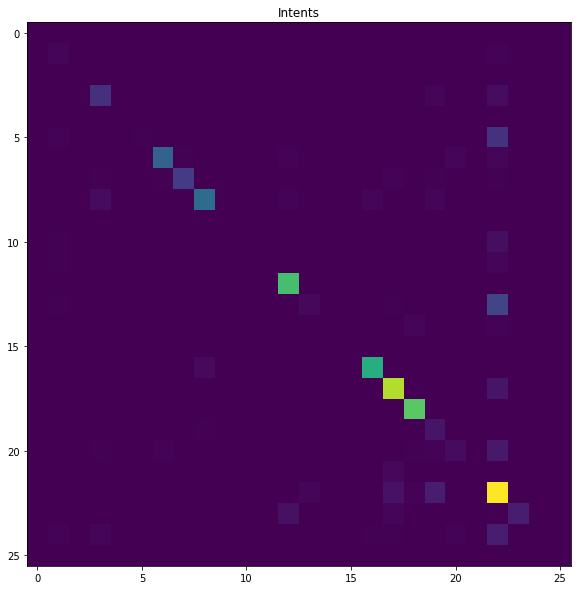

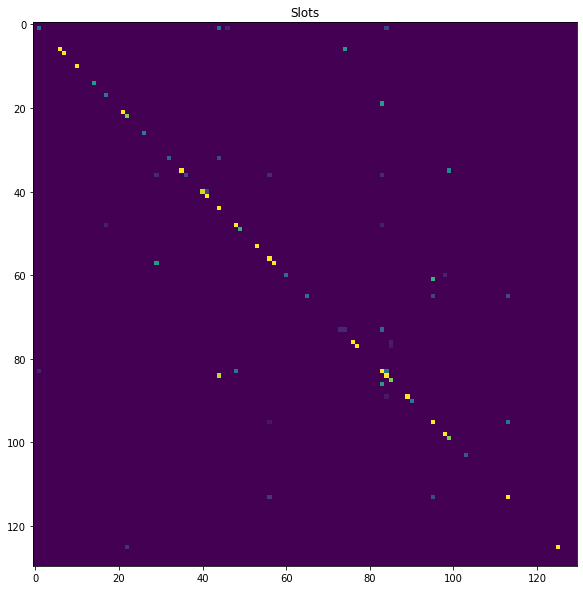

In [116]:
plot_confusion_matrix(ATIS_first_cm_intent, label="Intents")
plot_confusion_matrix(ATIS_first_cm_slot, label="Slots")

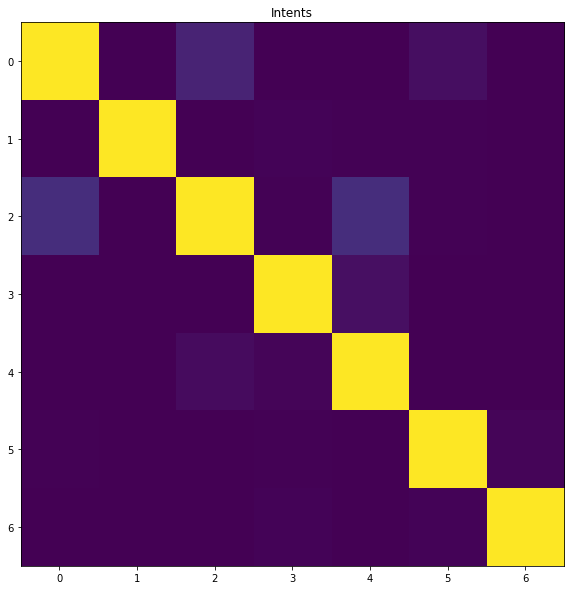

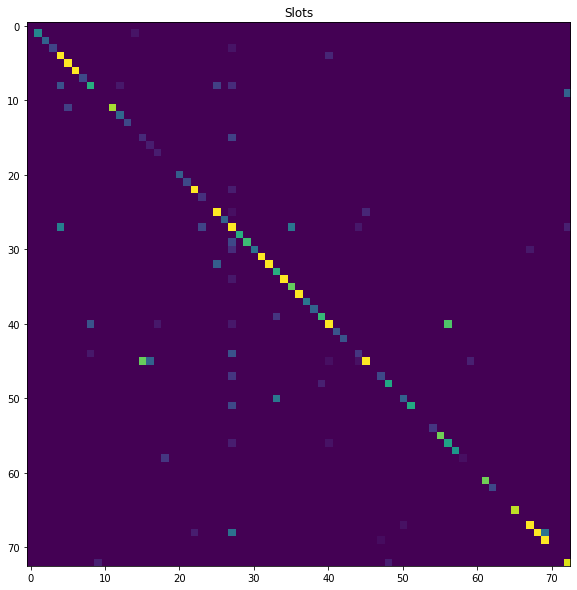

In [117]:
plot_confusion_matrix(SNIPS_first_cm_intent, label="Intents")
plot_confusion_matrix(SNIPS_first_cm_slot, label="Slots")

### Second model

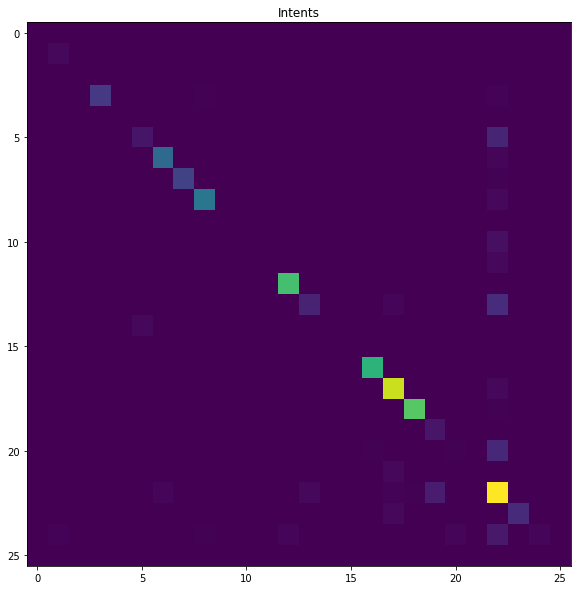

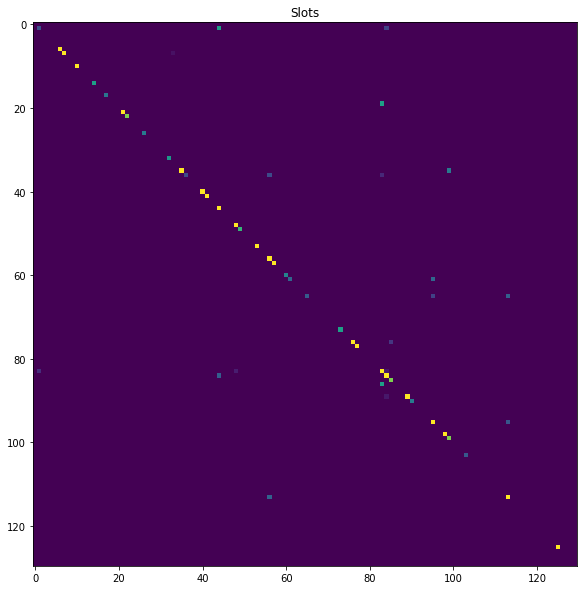

In [118]:
plot_confusion_matrix(ATIS_second_cm_intent, label="Intents")
plot_confusion_matrix(ATIS_second_cm_slot, label="Slots")

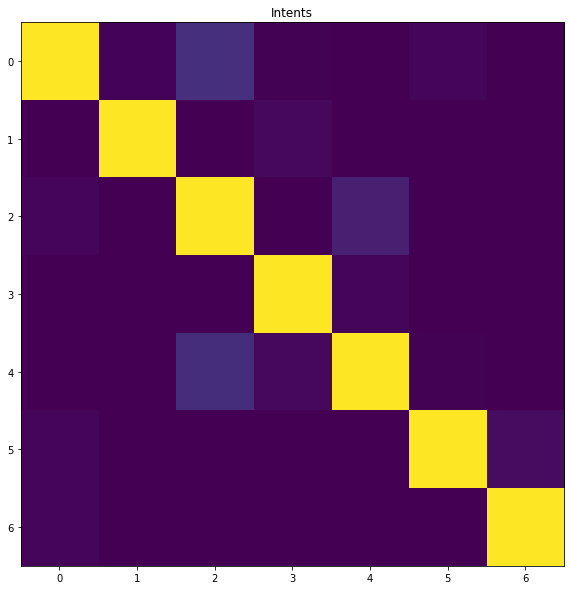

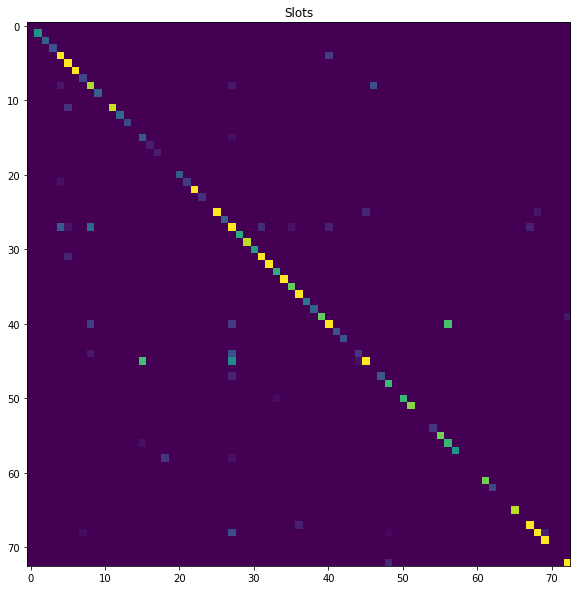

In [119]:
plot_confusion_matrix(SNIPS_second_cm_intent, label="Intents")
plot_confusion_matrix(SNIPS_second_cm_slot, label="Slots")

## Third model

### Monodirectional

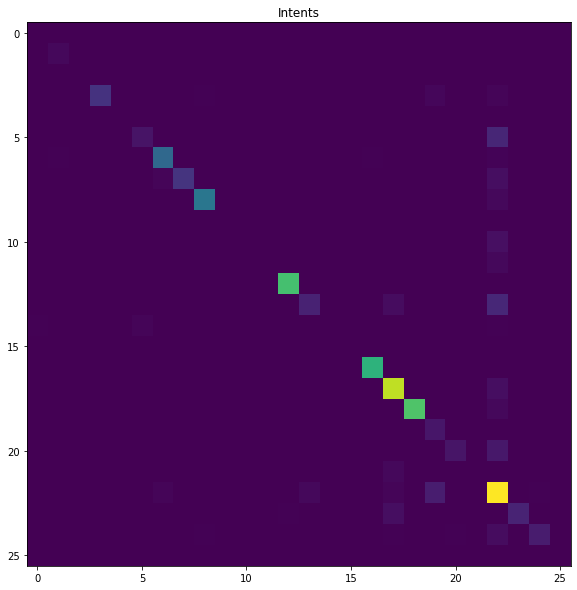

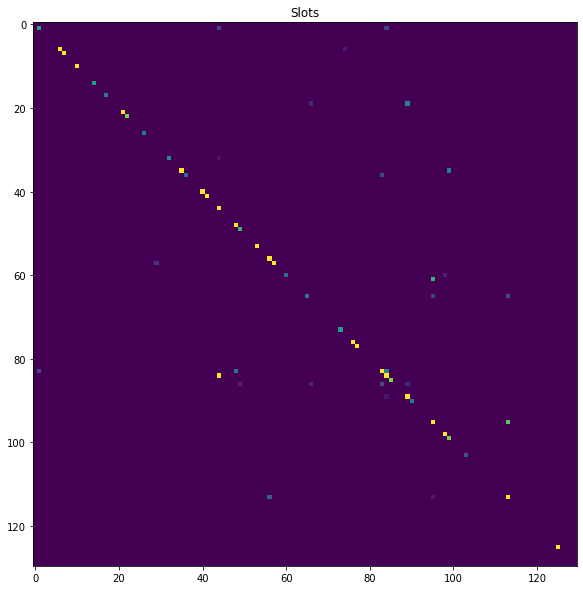

In [120]:
plot_confusion_matrix(ATIS_third_monodirectional_cm_intent, label="Intents")
plot_confusion_matrix(ATIS_third_monodirectional_cm_slot, label="Slots")

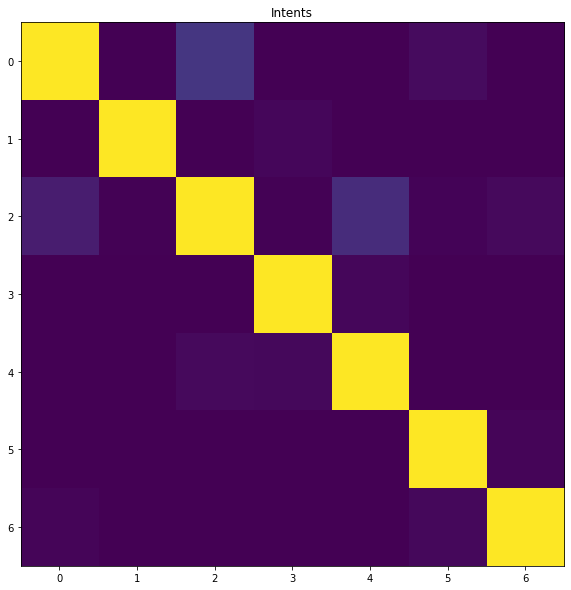

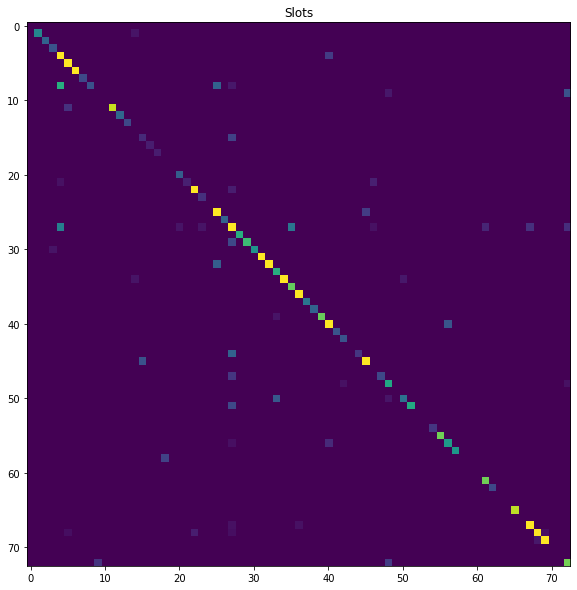

In [121]:
plot_confusion_matrix(SNIPS_third_monodirectional_cm_intent, label="Intents")
plot_confusion_matrix(SNIPS_third_monodirectional_cm_slot, label="Slots")

### Bidirectional

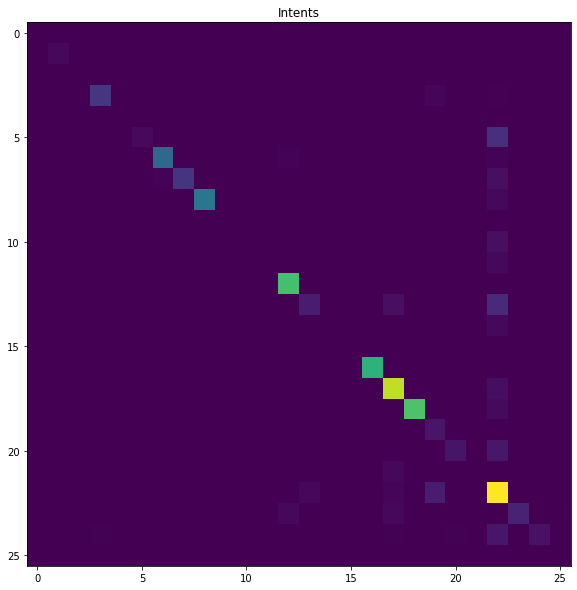

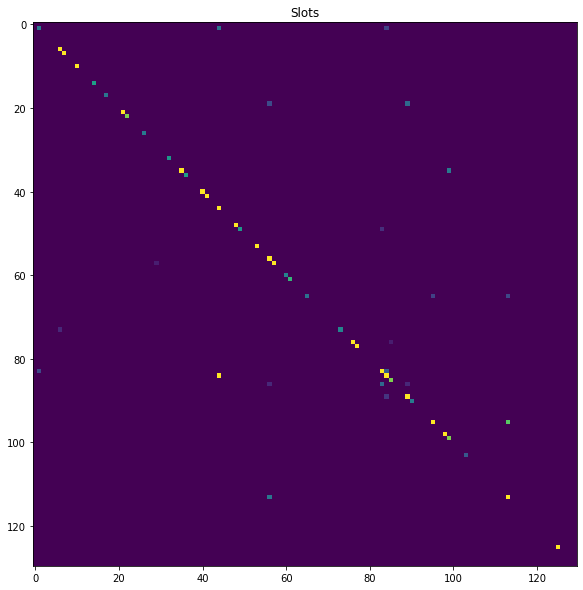

In [122]:
plot_confusion_matrix(ATIS_third_bidirectional_cm_intent, label="Intents")
plot_confusion_matrix(ATIS_third_bidirectional_cm_slot, label="Slots")

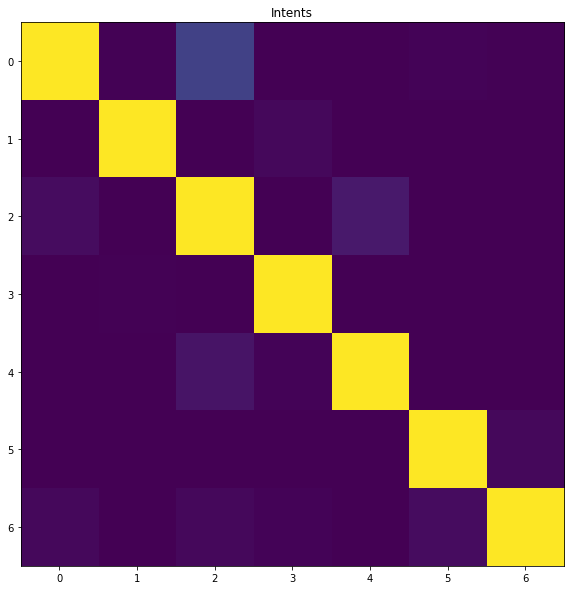

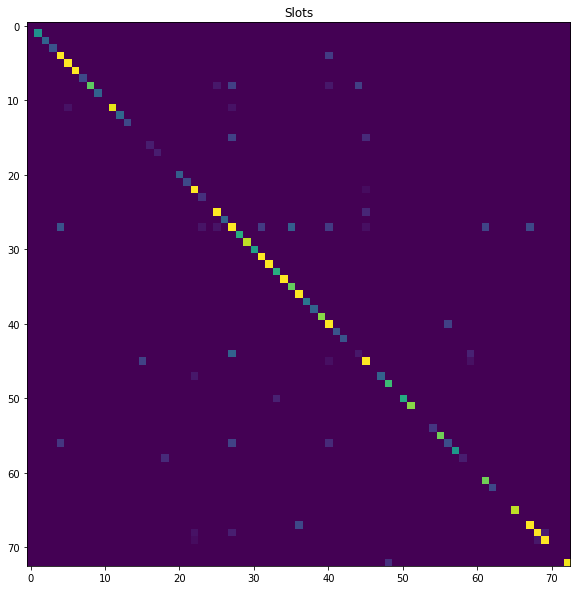

In [123]:
plot_confusion_matrix(SNIPS_third_bidirectional_cm_intent, label="Intents")
plot_confusion_matrix(SNIPS_third_bidirectional_cm_slot, label="Slots")